In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
from scipy.spatial.distance import pdist, cdist, squareform
from ete3 import PhyloTree
import tqdm

%matplotlib inline

from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id, get_ingroup_root, get_tree_len
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
from pymutspec.draw.sbs_orders import ordered_sbs192_kp
from pymutspec.annotation.spectra import (
    jackknife_spectra_sampling, calc_edgewise_spectra,
    complete_sbs192_columns, collapse_sbs192, get_cossim,
)

from utils import assign_cat

## Load data

### Check invar sites intersection

In [2]:
r_nd1 = pd.concat([
    pd.read_csv("../data/exposure/mammals_nd1/states/gtr.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_nd1/states/strsym.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_nd1/states/unrest.rate", comment="#", sep="\t"),
], ignore_index=True).groupby("Site").Cat.value_counts().unstack().fillna(0).astype(np.int8)

r_cytb = pd.concat([
    pd.read_csv("../data/exposure/mammals_cytb/states/gtr.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_cytb/states/strsym.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_cytb/states/unrest.rate", comment="#", sep="\t"),
], ignore_index=True).groupby("Site").Cat.value_counts().unstack().fillna(0).astype(np.int8)

#### Different model assign different cats to same sites

In [3]:
r_nd1[r_nd1.max(axis=1) < 2]

Cat,0,1,2,3,4,5,6
Site,,,,,,,
48,0,0,0,0,1,1,1
222,0,0,0,0,1,1,1
229,0,0,0,1,1,1,0
234,0,0,0,0,1,1,1
246,0,0,0,0,1,1,1
265,0,0,0,1,1,1,0
369,0,0,0,0,1,1,1
396,0,0,0,0,1,1,1
405,0,0,0,0,1,1,1


In [4]:
r_cytb[r_cytb.max(axis=1) < 2]

Cat,0,1,2,3,4,5,6
Site,,,,,,,
72,0,0,0,0,1,1,1
240,0,0,0,0,1,1,1
426,0,0,0,0,1,1,1
477,0,0,0,0,1,1,1
712,0,0,0,1,1,1,0
1096,0,0,1,1,1,0,0


#### But invariable sites are same for each model

In [5]:
r_nd1[r_nd1[0] > 0][0].value_counts()

3    181
Name: 0, dtype: int64

In [6]:
r_cytb[r_cytb[0] > 0][0].value_counts()

3    267
Name: 0, dtype: int64

### Load rates and cats

In [7]:
dtypes_rate = {"Site": np.int16, "Cat": np.int8}

rate_nd1 = pd.read_csv("../data/exposure/mammals_nd1/states/gtr.rate", comment="#", sep="\t", dtype=dtypes_rate)
rate_cytb = pd.read_csv("../data/exposure/mammals_cytb/states/gtr.rate", comment="#", sep="\t", dtype=dtypes_rate)
rate_cytb.head()

,Site,Rate,Cat,C_Rate
0,1,0.00187,0,0.00000
1,2,0.00003,0,0.00000
2,3,0.01569,1,0.01569
3,4,0.19571,2,0.12291
4,5,0.37341,3,0.37341


### Load observed mutations

In [8]:
dtypes = dict(
    Mut=str,
    Label=np.int8, 
    PosInGene=np.int16,
    ProbaMut=np.float32, 
    ProbaFull=np.float32,
    RefNode=str,
    AltNode=str,
)
usecols = list(dtypes.keys())
usecols_simple = [x for x in usecols if not x.startswith("Proba")]

PATH_TO_DATA = "../data/exposure/mammals_nd1/"
mut_nd1 = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/mutations.tsv"),  dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/mutations.tsv"),  dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="strsym"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/mutations.tsv"),   dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY8.8"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/mutations.tsv"),    dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/mutations.tsv"),dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY10.12_simple"),

    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/mutations.tsv"),     dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(ProbaMut=1., ProbaRef=1., ProbaFull=1.))

mut_nd1["MutBase"] = mut_nd1["Mut"].str.slice(2, 5).astype("category")


PATH_TO_DATA = "../data/exposure/mammals_cytb/"
mut_cytb = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/mutations.tsv"),  dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/mutations.tsv"),  dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="strsym"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/mutations.tsv"),   dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY8.8"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/mutations.tsv"),    dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/mutations.tsv"),dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY10.12_simple"),

    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/mutations.tsv"),     dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(ProbaMut=1., ProbaRef=1., ProbaFull=1.))

mut_cytb["MutBase"] = mut_cytb["Mut"].str.slice(2, 5).astype("category")

mut_nd1 = mut_nd1[mut_nd1.RefNode != "ROOT"]
mut_cytb = mut_cytb[mut_cytb.RefNode != "ROOT"]

mut_nd1 = mut_nd1.merge(rate_nd1[["Site", "Cat"]].rename(columns={"Site": "PosInGene"}), on="PosInGene")
mut_cytb = mut_cytb.merge(rate_cytb[["Site", "Cat"]].rename(columns={"Site": "PosInGene"}), on="PosInGene")

In [9]:
mut_cytb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2455647 entries, 0 to 2455646
Data columns (total 10 columns):
 #   Column     Dtype   
---  ------     -----   
 0   Mut        object  
 1   Label      int8    
 2   PosInGene  int16   
 3   RefNode    object  
 4   AltNode    object  
 5   Aproach    object  
 6   ProbaMut   float32 
 7   ProbaFull  float32 
 8   MutBase    category
 9   Cat        int8    
dtypes: category(1), float32(2), int16(1), int8(2), object(4)
memory usage: 124.1+ MB


### Load expected mutations freqs

In [10]:
dtypes_exp = dict(
    Mut=str,
    Label=str, 
    Pos=np.int16,
    Proba=np.float32, 
    Node=str,
)
usecols_exp = list(dtypes_exp.keys())
usecols_exp_simple = [x for x in usecols_exp if not x.startswith("Proba")]

PATH_TO_DATA = "../data/exposure/mammals_cytb/"
exp_cytb = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/expected_mutations.tsv"),   dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY8.8"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="strsym"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/expected_mutations.tsv"),    dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/expected_mutations.tsv"),dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY10.12_simple"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/expected_mutations.tsv"),     dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/expected_mutations.tsv"),        dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(Proba=1.))


PATH_TO_DATA = "../data/exposure/mammals_nd1/"
exp_nd1 = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="strsym"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/expected_mutations.tsv"),   dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY8.8"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/expected_mutations.tsv"),    dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/expected_mutations.tsv"),dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY10.12_simple"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/expected_mutations.tsv"),     dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/expected_mutations.tsv"),        dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(Proba=1.))

exp_nd1 = exp_nd1[(exp_nd1.Mut.isin(possible_sbs192)) & (exp_nd1.Node != "ROOT")]
exp_cytb = exp_cytb[(exp_cytb.Mut.isin(possible_sbs192)) & (exp_cytb.Node != "ROOT")]

exp_nd1["Cat"] = exp_nd1.Pos.map(rate_nd1.set_index("Site").Cat.to_dict()).astype(np.int8)
exp_cytb["Cat"] = exp_cytb.Pos.map(rate_cytb.set_index("Site").Cat.to_dict()).astype(np.int8)

In [11]:
exp_cytb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47270795 entries, 0 to 51050686
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Pos      int16  
 1   Mut      object 
 2   Label    object 
 3   Node     object 
 4   Aproach  object 
 5   Proba    float32
 6   Cat      int8   
dtypes: float32(1), int16(1), int8(1), object(4)
memory usage: 2.1+ GB


### Add phylocoef of alt node

In [12]:
#calculate node-specific phylocoefs

tree_cytb = PhyloTree("../data/exposure/mammals_cytb/iqtree_anc_tree.nwk", format=1)
tree_nd1  = PhyloTree("../data/exposure/mammals_nd1/iqtree_anc_tree.nwk", format=1)


# TODO correct phylocoefs BOTH
max_dist_cytb = get_tree_len(get_ingroup_root(tree_cytb), 'geom_mean')
dist2leaf_cytb = {}
phylocoefs_cytb = {}
for node in tree_cytb.iter_descendants():
    d = node.get_closest_leaf()[1]
    dist2leaf_cytb[node.name]  = d
    phylocoefs_cytb[node.name] = 1 - min(0.9999, d / max_dist_cytb)

max_dist_nd1 = get_tree_len(get_ingroup_root(tree_nd1), 'geom_mean')
dist2leaf_nd1 = {}
phylocoefs_nd1 = {}
for node in tree_nd1.iter_descendants():
    d = node.get_closest_leaf()[1]
    dist2leaf_nd1[node.name]  = d
    phylocoefs_nd1[node.name] = 1 - min(0.9999, d / max_dist_nd1)

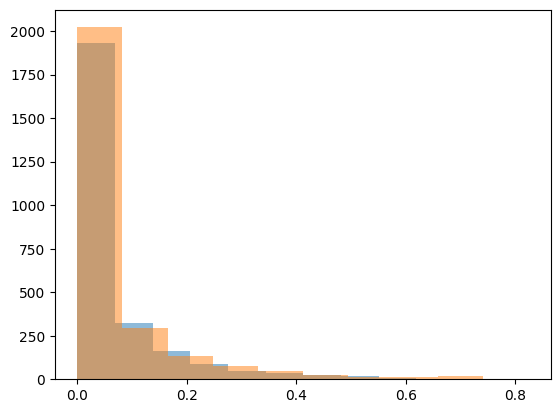

In [13]:
plt.hist(dist2leaf_cytb.values(), alpha=0.5);
plt.hist(dist2leaf_nd1.values(), alpha=0.5);

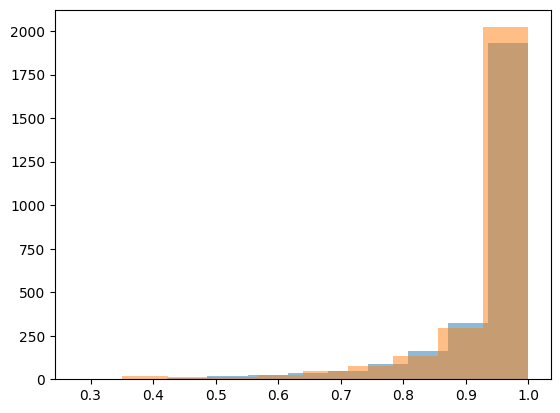

In [14]:
plt.hist(phylocoefs_cytb.values(), alpha=0.5);
plt.hist(phylocoefs_nd1.values(), alpha=0.5);

In [15]:
# update 'ProbaFull' for OBS ND1
mut_nd1['RefPhylocoef'] = mut_nd1['ProbaFull'] / mut_nd1['ProbaMut']
mut_nd1['RefPhylocoefTrue'] = mut_nd1.RefNode.map(phylocoefs_nd1).astype(np.float32)
mut_nd1['AltPhylocoefTrue'] = mut_nd1.AltNode.map(phylocoefs_nd1).astype(np.float32)
mut_nd1['PhylocoefTotal'] = 1
mut_nd1.loc[mut_nd1.Aproach.isin(['gtr', 'RY10.12']), 'PhylocoefTotal'] = mut_nd1.loc[mut_nd1.Aproach.isin(['gtr', 'RY10.12']), 'RefPhylocoefTrue'] \
                                                                        * mut_nd1.loc[mut_nd1.Aproach.isin(['gtr', 'RY10.12']), 'AltPhylocoefTrue']
mut_nd1['ProbaFull2'] = mut_nd1['ProbaMut'] * mut_nd1['PhylocoefTotal']

# update 'ProbaFull' for OBS CYTB
mut_cytb['RefPhylocoef'] = mut_cytb['ProbaFull'] / mut_cytb['ProbaMut']
mut_cytb['RefPhylocoefTrue'] = mut_cytb.RefNode.map(phylocoefs_cytb).astype(np.float32)
mut_cytb['AltPhylocoefTrue'] = mut_cytb.AltNode.map(phylocoefs_cytb).astype(np.float32)
mut_cytb['PhylocoefTotal'] = 1
mut_cytb.loc[mut_cytb.Aproach.isin(['gtr', 'RY10.12']), 'PhylocoefTotal'] = mut_cytb.loc[mut_cytb.Aproach.isin(['gtr', 'RY10.12']), 'RefPhylocoefTrue'] \
                                                                          * mut_cytb.loc[mut_cytb.Aproach.isin(['gtr', 'RY10.12']), 'AltPhylocoefTrue']
mut_cytb['ProbaFull2'] = mut_cytb['ProbaMut'] * mut_cytb['PhylocoefTotal']

In [16]:
mut_nd1[mut_nd1.Aproach.isin(['gtr', 'RY10.12'])].sample(10)

,Mut,Label,PosInGene,RefNode,AltNode,Aproach,ProbaMut,ProbaFull,MutBase,Cat,RefPhylocoef,RefPhylocoefTrue,AltPhylocoefTrue,PhylocoefTotal,ProbaFull2
15142,G[A>G]T,2,474,Node1261,Node1262,gtr,0.147661,0.140438,A>G,5,0.951084,0.862301,0.871412,0.751419,0.110955
1873294,A[T>C]C,1,279,Node1104,Node1105,gtr,0.062121,0.060917,T>C,6,0.980622,0.945452,0.981352,0.927821,0.057637
560266,C[A>C]T,2,591,Node1164,RN_719,RY10.12,0.399570,0.388965,A>C,6,0.973459,0.925287,1.000000,0.925287,0.369717
1994609,A[A>G]T,0,793,Node65,Node601,gtr,0.011098,0.008668,A>G,5,0.781004,0.383527,0.394451,0.151282,0.001679
1565394,T[G>A]T,1,516,Node91,RN_174,gtr,0.060270,0.054997,G>A,6,0.912517,0.753735,1.000000,0.753735,0.045428
2021158,A[C>T]T,1,316,Node861,Node862,RY10.12,0.620448,0.602115,C>T,5,0.970452,0.916823,0.922433,0.845707,0.524717
1855467,C[T>C]C,2,246,Node1303,Node1304,RY10.12,0.170467,0.164801,T>C,6,0.966763,0.906437,0.934829,0.847364,0.144447
163117,T[T>C]A,1,777,Node109,Node110,gtr,0.291952,0.271061,T>C,5,0.928445,0.798573,0.865431,0.691110,0.201771
1981283,T[T>C]A,0,206,Node354,Node355,gtr,0.417985,0.338999,T>C,3,0.811033,0.468059,0.999998,0.468058,0.195641
1163298,C[G>A]A,2,768,Node72,Node73,RY10.12,0.059972,0.050330,G>A,6,0.839214,0.547388,0.612143,0.335080,0.020095


In [17]:
mut_nd1.groupby('Aproach').apply(lambda x: x.ProbaFull - x.ProbaFull2).mean(level=0)

Aproach
RY10.12           0.030590
RY10.12_simple    0.000000
gtr               0.029998
gtr_simple        0.000000
pastml            0.000000
dtype: float64

In [18]:
mut_cytb.groupby('Aproach').apply(lambda x: x.ProbaFull - x.ProbaFull2).mean(level=0)

Aproach
RY10.12           0.028916
RY10.12_simple    0.000000
gtr               0.028050
gtr_simple        0.000000
pastml            0.000000
dtype: float64

<AxesSubplot:>

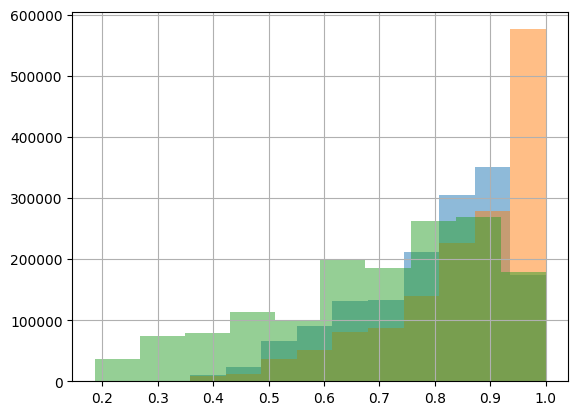

In [19]:
mut_cytb.loc[mut_cytb.Aproach.isin(['gtr', 'RY10.12']), 'RefPhylocoefTrue'].hist(alpha=0.5)
mut_cytb.loc[mut_cytb.Aproach.isin(['gtr', 'RY10.12']), 'AltPhylocoefTrue'].hist(alpha=0.5)
mut_cytb.loc[mut_cytb.Aproach.isin(['gtr', 'RY10.12']), 'PhylocoefTotal'].hist(alpha=0.5)

In [20]:
mut_cytb['ProbaNotFull'] = mut_cytb['ProbaFull']
mut_nd1['ProbaNotFull'] = mut_nd1['ProbaFull']

mut_cytb['ProbaFull'] = mut_cytb['ProbaFull2']
mut_nd1['ProbaFull'] = mut_nd1['ProbaFull2']

#### Update proba in EXP

In [21]:
mut_cytb[mut_cytb.Aproach == 'gtr']

,Mut,Label,PosInGene,RefNode,AltNode,Aproach,ProbaMut,ProbaFull,MutBase,Cat,RefPhylocoef,RefPhylocoefTrue,AltPhylocoefTrue,PhylocoefTotal,ProbaFull2,ProbaNotFull
277,T[A>G]A,1,33,Node208,Node209,gtr,0.017714,0.006509,A>G,5,0.812709,0.560181,0.655977,0.367466,0.006509,0.014397
278,T[C>A]A,0,33,Node208,Node209,gtr,0.080637,0.029631,C>A,5,0.812709,0.560181,0.655977,0.367466,0.029631,0.065534
279,T[C>G]A,0,33,Node208,Node209,gtr,0.013268,0.004876,C>G,5,0.812709,0.560181,0.655977,0.367466,0.004876,0.010783
280,T[C>A]A,2,33,Node208,Node209,gtr,0.015612,0.005737,C>A,5,0.812709,0.560181,0.655977,0.367466,0.005737,0.012688
281,T[T>A]A,0,33,Node208,Node209,gtr,0.179071,0.065802,T>A,5,0.812709,0.560181,0.655977,0.367466,0.065802,0.145533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455607,G[C>A]C,0,1099,Node867,RN_1020,gtr,0.142682,0.134332,C>A,1,0.975078,0.941475,1.000000,0.941475,0.134332,0.139126
2455612,A[G>A]A,0,214,Node855,RN_1215,gtr,0.091059,0.070928,G>A,1,0.905858,0.778926,1.000000,0.778926,0.070928,0.082487
2455615,T[G>A]G,0,499,Node855,RN_1215,gtr,0.165699,0.129067,G>A,1,0.905858,0.778926,1.000000,0.778926,0.129067,0.150100
2455618,G[G>C]T,0,1019,Node150,RN_105,gtr,0.197260,0.171907,G>C,1,0.945269,0.871475,1.000000,0.871475,0.171907,0.186464


In [22]:
n2phylocoef_old_cytb = mut_cytb[mut_cytb.Aproach == 'gtr'].groupby('RefNode').RefPhylocoef.mean().to_dict()
n2phylocoef_old_nd1 = mut_nd1[mut_nd1.Aproach == 'gtr'].groupby('RefNode').RefPhylocoef.mean().to_dict()

In [23]:
exp_cytb['phylocoef'] = 1
exp_cytb['phylocoef_old'] = 1
exp_cytb.loc[exp_cytb.Aproach.isin(['gtr', 'RY10.12']), 'phylocoef'] = exp_cytb.loc[exp_cytb.Aproach.isin(['gtr', 'RY10.12']), 'Node'].map(phylocoefs_cytb).astype(np.float32)
exp_cytb.loc[exp_cytb.Aproach.isin(['gtr', 'RY10.12']), 'phylocoef_old'] = exp_cytb.loc[exp_cytb.Aproach.isin(['gtr', 'RY10.12']), 'Node'].map(n2phylocoef_old_cytb)
exp_cytb['phylocoef_old'] = exp_cytb['phylocoef_old'].fillna(1.).astype(np.float32)
exp_cytb['ProbaMut'] = exp_cytb['Proba'] / exp_cytb['phylocoef_old']
exp_cytb['Proba2'] = exp_cytb['ProbaMut'] * exp_cytb['phylocoef']

exp_nd1['phylocoef'] = 1
exp_nd1['phylocoef_old'] = 1
exp_nd1.loc[exp_nd1.Aproach.isin(['gtr', 'RY10.12']), 'phylocoef'] = exp_nd1.loc[exp_nd1.Aproach.isin(['gtr', 'RY10.12']), 'Node'].map(phylocoefs_nd1).astype(np.float32)
exp_nd1.loc[exp_nd1.Aproach.isin(['gtr', 'RY10.12']), 'phylocoef_old'] = exp_nd1.loc[exp_nd1.Aproach.isin(['gtr', 'RY10.12']), 'Node'].map(n2phylocoef_old_nd1)
exp_nd1['phylocoef_old'] = exp_nd1['phylocoef_old'].fillna(1.).astype(np.float32)
exp_nd1['ProbaMut'] = exp_nd1['Proba'] / exp_nd1['phylocoef_old']
exp_nd1['Proba2'] = exp_nd1['ProbaMut'] * exp_nd1['phylocoef']

In [24]:
exp_cytb.sample(10)

,Pos,Mut,Label,Node,Aproach,Proba,Cat,phylocoef,phylocoef_old,ProbaMut,Proba2
20400297,576,T[A>T]G,syn,Node107,gtr,0.960166,5,0.947008,0.977434,0.982333,0.930278
20477876,582,G[A>C]G,syn_c,Node398,gtr,0.959516,5,0.922485,0.966991,0.992270,0.915354
28419647,630,G[G>A]C,syn,Node16,RY10.12,0.069305,6,0.650688,0.851250,0.081416,0.052976
24609995,206,A[T>A]T,all,Node543,gtr,0.113725,1,0.856618,0.938942,0.121120,0.103754
15548849,219,T[G>A]A,syn,Node231,gtr,0.059206,6,0.578708,0.820598,0.072150,0.041754
33153855,452,T[C>G]A,all,Node422,RY10.12,0.967345,1,0.924612,0.967897,0.999430,0.924085
13851658,712,C[T>G]T,all,Node651,RY10.12_simple,1.000000,4,1.000000,1.000000,1.000000,1.000000
33291543,981,T[C>G]T,all,Node775,RY10.12,0.987159,6,0.971514,0.987870,0.999280,0.970815
4117976,846,G[C>G]T,syn,Node92,gtr_simple,1.000000,5,1.000000,1.000000,1.000000,1.000000
47667122,300,G[A>T]G,syn,Node978,pastml,0.987817,5,1.000000,1.000000,0.987817,0.987817


In [25]:
exp_cytb.iloc[[26782121]]

,Pos,Mut,Label,Node,Aproach,Proba,Cat,phylocoef,phylocoef_old,ProbaMut,Proba2
28935167,729,T[T>G]C,syn4f,Node478,RY10.12,0.059815,6,0.604906,0.831755,0.071915,0.043502


In [26]:
exp_cytb[exp_cytb.Aproach.isin(['gtr', 'RY10.12'])].sort_values('Proba2')

,Pos,Mut,Label,Node,Aproach,Proba,Cat,phylocoef,phylocoef_old,ProbaMut,Proba2
27661493,1103,C[T>C]G,all,Node300,RY10.12,0.036353,3,0.358676,0.726901,0.050012,0.017938
27661494,1103,C[T>G]G,all,Node300,RY10.12,0.036353,3,0.358676,0.726901,0.050012,0.017938
27661492,1103,C[T>A]G,all,Node300,RY10.12,0.036353,3,0.358676,0.726901,0.050012,0.017938
27647343,180,C[C>A]A,syn,Node300,RY10.12,0.036379,6,0.358676,0.726901,0.050047,0.017951
27647350,180,C[C>G]A,all,Node300,RY10.12,0.036379,6,0.358676,0.726901,0.050047,0.017951
...,...,...,...,...,...,...,...,...,...,...,...
26968105,156,C[A>C]A,syn,Node661,gtr,1.000000,6,0.999999,1.000000,1.000000,0.999999
26968107,156,C[A>C]A,syn_c,Node661,gtr,1.000000,6,0.999999,1.000000,1.000000,0.999999
26968108,156,C[A>G]A,syn_c,Node661,gtr,1.000000,6,0.999999,1.000000,1.000000,0.999999
26968110,156,C[A>C]A,all,Node661,gtr,1.000000,6,0.999999,1.000000,1.000000,0.999999


In [27]:
exp_cytb['ProbaNotFull'] = exp_cytb['Proba']
exp_nd1['ProbaNotFull'] = exp_nd1['Proba']

exp_cytb['Proba'] = exp_cytb['Proba2']
exp_nd1['Proba'] = exp_nd1['Proba2']

### How many mutations with diffrent types observed?

In [91]:
mutations_summary(mut_cytb, "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Aproach,,,,,,
RY10.12,7800,102464,53667,21,18,0
RY10.12_simple,10285,82701,41292,4,3,0
gtr,7815,102529,54660,21,18,0
gtr_simple,10356,82535,41547,4,3,0
pastml,10147,135584,62552,39,37,0


In [92]:
mutations_summary(mut_cytb[mut_cytb.ProbaFull > 0.3], "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
RY10.12,5345,51355,24673,0,0
RY10.12_simple,10285,82701,41292,4,3
gtr,5280,50832,24217,0,0
gtr_simple,10356,82535,41547,4,3
pastml,6458,65377,31351,1,1


In [93]:
mutations_summary(mut_nd1, "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
RY10.12,5958,82998,46146,4,2
RY10.12_simple,8360,68091,35728,6,3
gtr,5968,82665,46459,3,2
gtr_simple,8347,67617,35585,7,4
pastml,8074,109884,53672,6,3


In [94]:
mutations_summary(mut_nd1[mut_nd1.ProbaFull > 0.3], "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
RY10.12,4002,41658,20977,1,1
RY10.12_simple,8360,68091,35728,6,3
gtr,3979,41257,20648,0,1
gtr_simple,8347,67617,35585,7,4
pastml,5084,53086,26768,1,1


**Probability distribution of mutations**

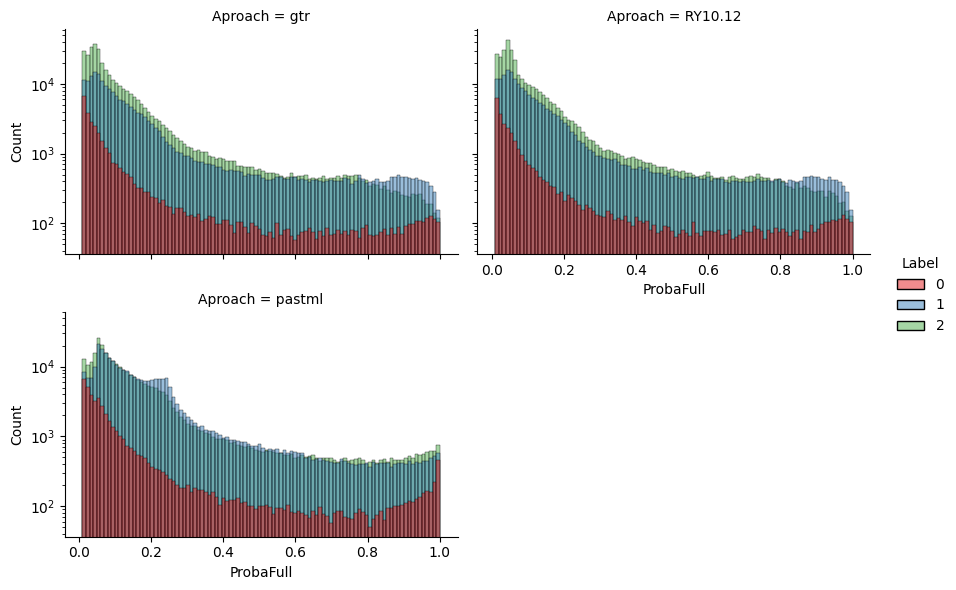

In [95]:
sns.displot(
    data=mut_nd1[(mut_nd1.Label >= 0) & (~mut_nd1.Aproach.str.contains("simple")) & (mut_nd1.ProbaFull > 0.01)], 
    x="ProbaFull", hue="Label", col="Aproach", col_wrap=2,
    log_scale=[False, True], bins=100, palette="Set1", aspect=1.5, height=3,
)
plt.show()

**Number of mutations in tree edges**

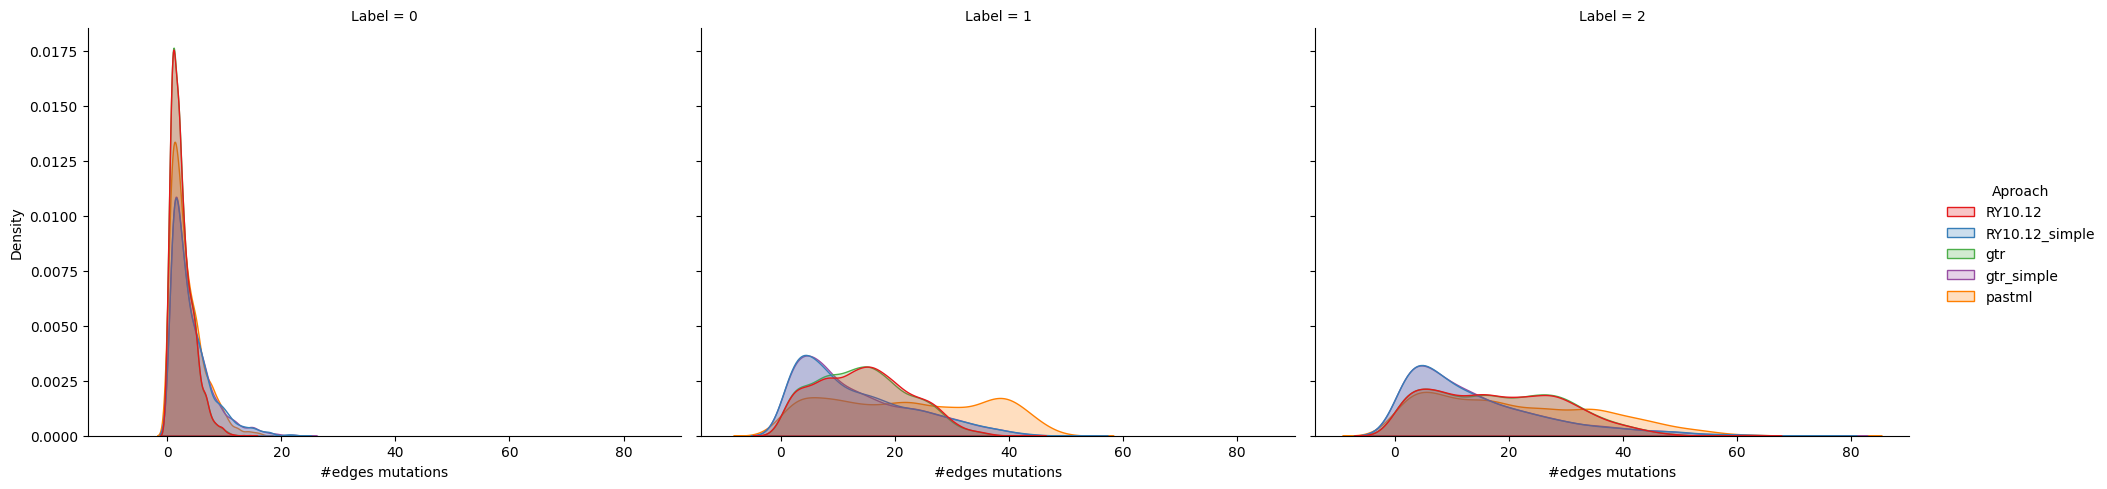

In [96]:
sns.displot(
    data=mut_nd1[mut_nd1.Label >= 0].groupby(["Aproach", "Label", "AltNode"]).ProbaFull.sum().reset_index(), 
    x="ProbaFull", col="Label", hue="Aproach", aspect=1.3, palette="Set1", kind="kde", fill=True,
).set_axis_labels("#edges mutations");
plt.show()

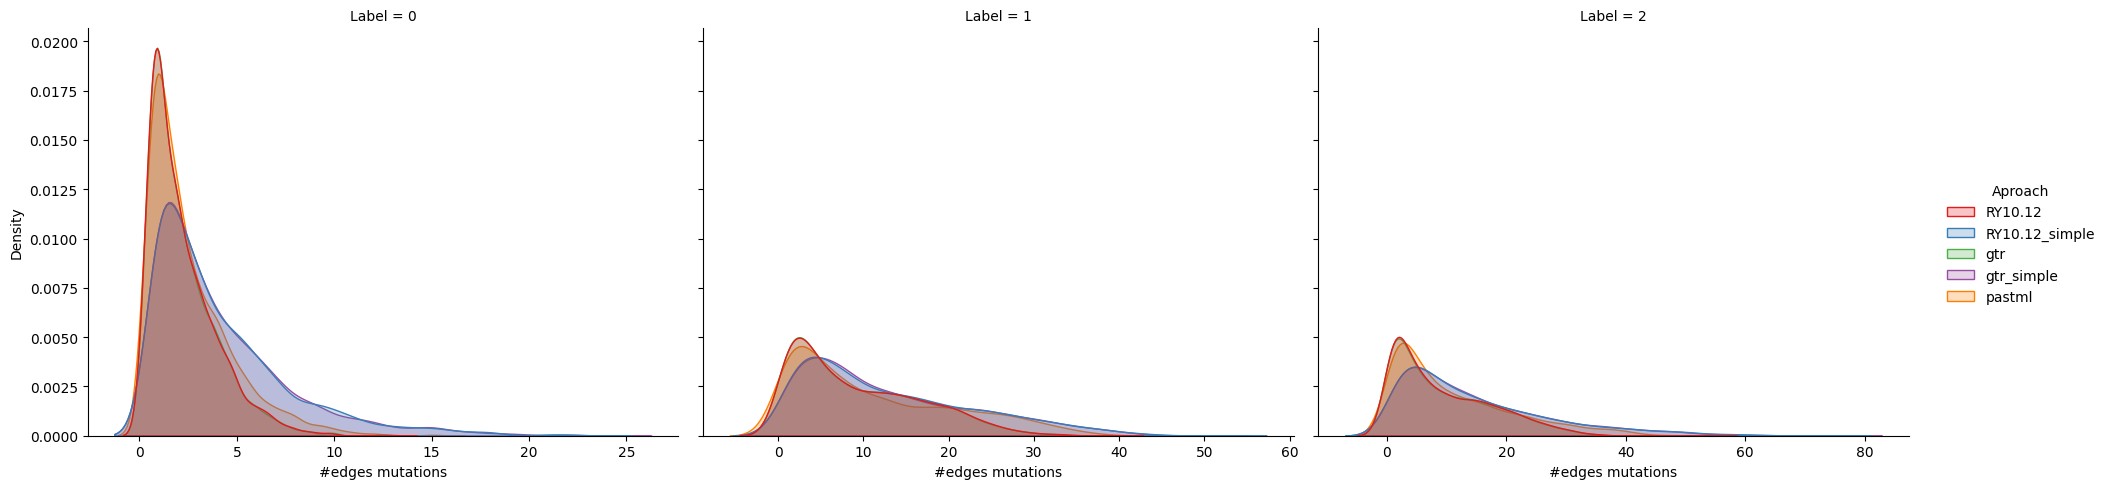

In [97]:
# after filtration (P > 0.3)
sns.displot(
    data=mut_nd1[(mut_nd1.Label >= 0) & (mut_nd1.ProbaFull > 0.3)].groupby(["Aproach", "Label", "AltNode"]).ProbaFull.sum().reset_index(), 
    x="ProbaFull", col="Label", hue="Aproach", aspect=1.3, palette="Set1", facet_kws=dict(sharex=False), kind="kde", fill=True,
).set_axis_labels("#edges mutations");
plt.show()

## QC of rate and probability

### Choose low-rate category cutoff

In [198]:
lbl = "syn"
pcutoff = 0.1

simple_approaches = [x for x in mut_cytb.Aproach.unique() if "simple" in x]

obs_cytb_syn = mut_cytb[(~mut_cytb.Aproach.isin(simple_approaches)) & (mut_cytb.Label >= lbl2lbl_id(lbl))  & (mut_cytb.ProbaFull >= pcutoff)]
obs_nd1_syn  = mut_nd1[(~mut_nd1.Aproach.isin(simple_approaches))   & (mut_nd1.Label   >= lbl2lbl_id(lbl)) & (mut_nd1.ProbaFull  >= pcutoff)]
exp_cytb_syn = exp_cytb[(~exp_cytb.Aproach.isin(simple_approaches)) & (exp_cytb.Label == lbl)  & (exp_cytb.Proba >= pcutoff)]
exp_nd1_syn  = exp_nd1[(~exp_nd1.Aproach.isin(simple_approaches))   & (exp_nd1.Label   == lbl) & (exp_nd1.Proba  >= pcutoff)]

obs_cytb_syn.loc[obs_cytb_syn.Cat < 3, "Cat"] = 3
obs_nd1_syn.loc[obs_nd1_syn.Cat < 3,   "Cat"] = 3
exp_cytb_syn.loc[exp_cytb_syn.Cat < 3, "Cat"] = 3
exp_nd1_syn.loc[exp_nd1_syn.Cat < 3,   "Cat"] = 3

In [199]:
data = []
for gene, mut, exp in zip(["cytb", "nd1"], 
                          [obs_cytb_syn, obs_nd1_syn], 
                          [exp_cytb_syn, exp_nd1_syn]):

    for (appr, rcat), obs_cur in mut.groupby(["Aproach", "Cat"]):    
        # if obs_cur.ProbaFull.sum() < 50 or obs_cur.Mut.nunique() < 16:
        #     print(appr, rcat, "- pass")
        #     break

        exp_cur = exp[(exp.Aproach == appr) & (exp.Cat == rcat)]
        
        # print(obs_cur.AltNode.nunique())
        # if obs_cur.AltNode.nunique() == 1960:
        #     break

        spectra = jackknife_spectra_sampling(obs_cur, exp_cur, n=100)
        # spectra = calc_edgewise_spectra(obs_cur, exp_cur, 0, 0)
        spectra = spectra.assign(Gene=gene, Aproach=appr, RateCat=rcat)\
            .set_index(["Gene", "Aproach", "RateCat"])
        data.append(spectra)
    
    print(gene)

spectra_cats_to_compare = pd.concat(data)

cytb
nd1


In [200]:
# _sr = spectra_cats_to_compare.mean(level=[0,1,2])
# _srd = pd.DataFrame(1 - squareform(pdist(_sr, "cosine")), index=_sr.index, columns=_sr.index)

_srd = a = pd.DataFrame(1 - squareform(pdist(spectra_cats_to_compare, "cosine")), 
                        index=spectra_cats_to_compare.index, columns=spectra_cats_to_compare.index) 

data = []
for g in _srd.index.levels[0]:
    for appr in _srd.index.levels[1]:
        a = _srd.loc[(g, appr), (g, appr)]
        a.index.rename("RateCat1", inplace=True)
        a.columns.rename("RateCat2", inplace=True)
        a = a.stack().mean(level=[0,1]).rename("Sim").reset_index()
        a["Gene"] = g
        a["Approach"] = appr
        data.append(a)

sim_df_mean = pd.concat(data)
sim_df_mean.head()

,RateCat1,RateCat2,Sim,Gene,Approach
0,3,3,0.886750,cytb,RY10.12
1,3,4,0.433701,cytb,RY10.12
2,3,5,0.498842,cytb,RY10.12
3,3,6,0.363924,cytb,RY10.12
4,4,3,0.433701,cytb,RY10.12


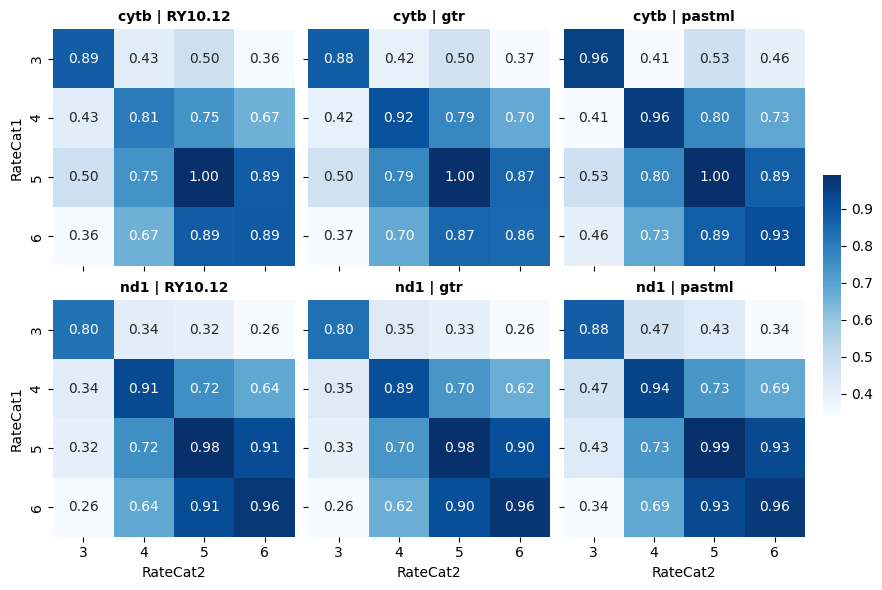

In [201]:
def facet_heatmap(data, color, **kws):
    data = data.pivot(index="RateCat1", columns='RateCat2', values='Sim')
    sns.heatmap(data, cmap='Blues', **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(sim_df_mean, row="Gene", col="Approach", size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    # vmin=0.4, vmax=1, 
                    annot=True, fmt=".2f")  # <-- Specify the colorbar axes and limits

g.set_titles("{row_name} | {col_name}", fontweight='bold', size=10)
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
plt.savefig(f"../figures/approaches/cossim_compare/ratecat_cutoff_search_{lbl}_pcutoff_{pcutoff}.pdf")
plt.show()

In [202]:
# plt.figure(figsize=(20, 10))
# plt.subplot(121)
# plt.title("Cytb")
# sns.heatmap(_srd.loc["cytb", "cytb"], cbar=False, cmap="coolwarm", annot=True, annot_kws={"size": 10}, fmt=".2f", vmin=0.5, vmax=1.0)

# plt.subplot(122)
# plt.title("ND1")
# sns.heatmap(_srd.loc["nd1", "nd1"], cbar=False, cmap="coolwarm", annot=True, annot_kws={"size": 10}, fmt=".2f", vmin=0.5, vmax=1.0)
# plt.show()

**Conclusion: positions of 4 rate-category too different from 6 and even 5 cats**

### Choose low-probability cutoff

On high-rate spectra

In [203]:
lbl = "syn"
low_cat = 4

obs_cytb_syn = mut_cytb[(mut_cytb.Label >= lbl2lbl_id(lbl)) & (mut_cytb.Cat > low_cat)]
obs_nd1_syn  = mut_nd1[(mut_nd1.Label   >= lbl2lbl_id(lbl)) & (mut_nd1.Cat  > low_cat)]
exp_cytb_syn = exp_cytb[(exp_cytb.Label == lbl) & (exp_cytb.Cat > low_cat)]
exp_nd1_syn  = exp_nd1[(exp_nd1.Label   == lbl) & (exp_nd1.Cat  > low_cat)]

obs_cytb_syn["ProbaCat"] = obs_cytb_syn["ProbaFull"].apply(assign_cat)
obs_nd1_syn ["ProbaCat"] = obs_nd1_syn ["ProbaFull"].apply(assign_cat)
exp_cytb_syn["ProbaCat"] = exp_cytb_syn["Proba"].apply(assign_cat)
exp_nd1_syn ["ProbaCat"] = exp_nd1_syn ["Proba"].apply(assign_cat)

In [204]:
obs_cytb_syn.tail(2)

,Mut,Label,PosInGene,RefNode,AltNode,Aproach,ProbaMut,ProbaFull,MutBase,Cat,RefPhylocoef,RefPhylocoefTrue,AltPhylocoefTrue,PhylocoefTotal,ProbaFull2,ProbaNotFull,ProbaCat
2422361,T[G>A]T,2,147,Node1182,RN_935,pastml,0.144964,0.144964,G>A,5,1.0,0.981224,1.0,1.0,0.144964,0.144964,0.1_0.2
2422362,T[G>A]T,2,147,Node1182,RN_936,pastml,0.144964,0.144964,G>A,5,1.0,0.981224,1.0,1.0,0.144964,0.144964,0.1_0.2


In [205]:
data = []
for gene, mut, exp in zip(["cytb", "nd1"], [obs_cytb_syn, obs_nd1_syn], [exp_cytb_syn, exp_nd1_syn]):
    for (appr, pcat), obs_cur in mut.groupby(["Aproach", "ProbaCat"]):
        if "simple" in appr or obs_cur.ProbaFull.sum() < 100 or obs_cur.Mut.nunique() < 16:
            print(appr, pcat, "- pass")
            continue

        exp_cur = exp[(exp.Aproach == appr) & (exp.ProbaCat == pcat) & exp.Node.isin(obs_cur.RefNode.values)]
        obs_cur = obs_cur[obs_cur.RefNode.isin(exp_cur.Node)]

        spectra = jackknife_spectra_sampling(obs_cur, exp_cur, n=100)
        # spectra = calc_edgewise_spectra(obs_cur, exp_cur, 0, 0, )
        spectra = spectra.assign(Gene=gene, Aproach=appr, ProbaCat=pcat).set_index(["Gene", "Aproach", "ProbaCat"], append=True)
        data.append(spectra)
        
    print(gene)

spectra_cats_to_compare = pd.concat(data)
spectra_cats_to_compare.reset_index(0, inplace=True)
# spectra_cats_to_compare.index = spectra_cats_to_compare.index.reorder_levels(order=['Gene', 'Aproach', 'ProbaCat', 'RefNode', 'AltNode'])

RY10.12_simple 0.9_1.0 - pass
gtr_simple 0.9_1.0 - pass
cytb
RY10.12_simple 0.9_1.0 - pass
gtr_simple 0.9_1.0 - pass
nd1


In [206]:
## jackknife sampling comparing

_srd = a = pd.DataFrame(1 - squareform(pdist(spectra_cats_to_compare, "cosine")), index=spectra_cats_to_compare.index, columns=spectra_cats_to_compare.index) 

data = []
for g in _srd.index.levels[0]:
    for appr in _srd.index.levels[1]:
        if "simple" in appr:
            continue
        a = _srd.loc[(g, appr), (g, appr)]
        a.index.rename("ProbaCat1", inplace=True)
        a.columns.rename("ProbaCat2", inplace=True)
        a = a.stack().mean(level=[0,1]).rename("Sim").reset_index()
        a["Gene"] = g
        a["Approach"] = appr
        data.append(a)

sim_df_mean = pd.concat(data)
sim_df_mean.head()


## edgewise comparing

# data = []
# for g in spectra_cats_to_compare.index.levels[0]:
#     for appr in spectra_cats_to_compare.index.levels[1]:
#         if "simple" in appr:
#             continue
#         for pc1, pc2 in combinations(spectra_cats_to_compare.index.levels[2], 2):
#             edges1 = spectra_cats_to_compare.loc[(g, appr, pc1)]
#             edges2 = spectra_cats_to_compare.loc[(g, appr, pc2)]
#             sim = get_cossim(edges1, edges2)
#             ava_sim = sim.mean()
#             data.append((g, appr, pc1, pc2, ava_sim))

# sim_df_mean = pd.DataFrame(data, columns=["Gene", "Approach", "ProbaCat1", "ProbaCat2", "Sim"])
# sim_df_mean.head()

,ProbaCat1,ProbaCat2,Sim,Gene,Approach
0,0.0_0.1,0.0_0.1,0.878299,cytb,RY10.12
1,0.0_0.1,0.1_0.2,0.866822,cytb,RY10.12
2,0.0_0.1,0.2_0.3,0.856374,cytb,RY10.12
3,0.0_0.1,0.3_0.4,0.840687,cytb,RY10.12
4,0.0_0.1,0.4_0.5,0.842161,cytb,RY10.12


In [207]:
sim_df_mean[(sim_df_mean.Gene == "cytb") & (sim_df_mean.Approach == "pastml")].pivot(index="ProbaCat1", columns='ProbaCat2', values='Sim').T

ProbaCat1,0.0_0.1,0.1_0.2,0.2_0.3,0.3_0.4,0.4_0.5,0.5_0.6,0.6_0.7,0.7_0.8,0.8_0.9,0.9_1.0
ProbaCat2,,,,,,,,,,
0.0_0.1,0.881295,0.858043,0.853906,0.849419,0.849377,0.842278,0.840040,0.839097,0.834378,0.829061
0.1_0.2,0.858043,0.887624,0.880959,0.876140,0.871261,0.867613,0.865096,0.864481,0.860500,0.856802
0.2_0.3,0.853906,0.880959,0.903643,0.907226,0.905373,0.903311,0.902091,0.901870,0.899944,0.898724
0.3_0.4,0.849419,0.876140,0.907226,0.943038,0.946153,0.946803,0.947166,0.947860,0.948612,0.952557
0.4_0.5,0.849377,0.871261,0.905373,0.946153,0.951615,0.952139,0.952566,0.953435,0.954832,0.959901
0.5_0.6,0.842278,0.867613,0.903311,0.946803,0.952139,0.953798,0.954202,0.955020,0.956933,0.962426
0.6_0.7,0.840040,0.865096,0.902091,0.947166,0.952566,0.954202,0.955366,0.955963,0.957971,0.963566
0.7_0.8,0.839097,0.864481,0.901870,0.947860,0.953435,0.955020,0.955963,0.957872,0.959208,0.965303
0.8_0.9,0.834378,0.860500,0.899944,0.948612,0.954832,0.956933,0.957971,0.959208,0.962428,0.968920


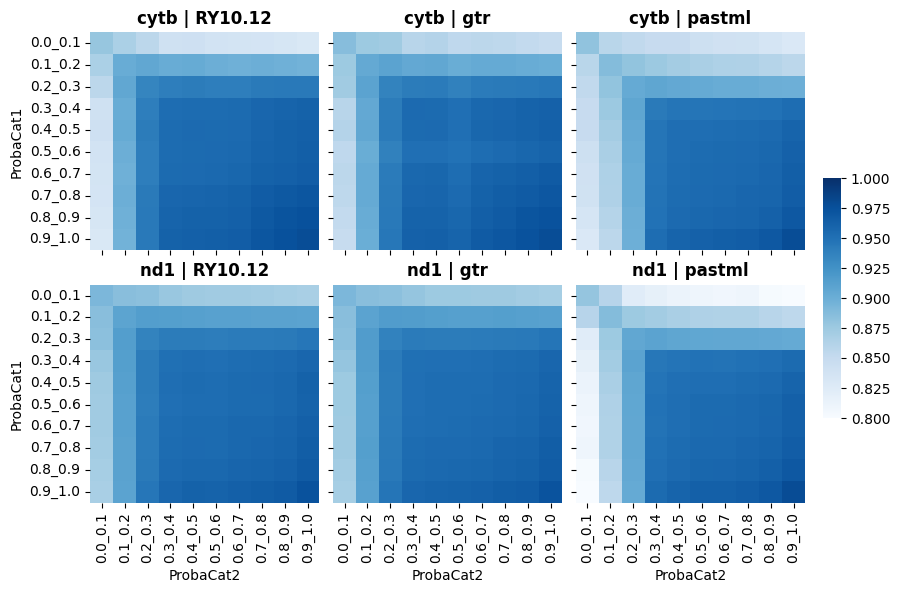

In [208]:
def facet_heatmap(data, color, **kws):
    data = data.pivot(index="ProbaCat1", columns='ProbaCat2', values='Sim')
    sns.heatmap(data, cmap='Blues', **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(sim_df_mean, row="Gene", col="Approach", size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0.8, vmax=1,
                    )  # <-- Specify the colorbar axes and limits

g.set_titles(template="{row_name} | {col_name}", fontweight='bold', size=12)
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
plt.savefig(f"../figures/approaches/cossim_compare/proba_cutoff_search_{lbl}_catcutoff_{low_cat}.pdf")
plt.show()

**Conclusion: [0, 0.3) are different categories**

## Compare PASTML with IQTREE

In [38]:
low_cat = 4
pcutoff = 0.3

#EXP
freqs_cytb_unfiltered = exp_cytb[exp_cytb.Cat.between(1, 4)].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.).reset_index()
freqs_nd1_unfiltered  = exp_nd1[exp_nd1.Cat.between(1, 4)].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.).reset_index()
freqs_cytb_filtered = exp_cytb[(exp_cytb.Cat > low_cat) & (exp_cytb.Proba > pcutoff)]\
    .groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.).reset_index()
freqs_nd1_filtered  = exp_nd1[(exp_nd1.Cat   > low_cat) & (exp_nd1.Proba  > pcutoff)]\
    .groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.).reset_index()

# assert freqs_nd1_high_rate.shape[1] == 192
# assert freqs_cytb_high_rate.shape[1] == 192

#OBS
obs_cytb_unfiltered = mut_cytb[mut_cytb.Cat.between(1, 4)].rename(columns={"PosInGene": "Site"})
obs_nd1_unfiltered  = mut_nd1[mut_nd1.Cat.between(1, 4)].rename(columns={"PosInGene": "Site"})
obs_cytb_filtered = mut_cytb[(mut_cytb.ProbaFull > pcutoff) & (mut_cytb.Cat > low_cat)].rename(columns={"PosInGene": "Site"})
obs_nd1_filtered  = mut_nd1[ (mut_nd1.ProbaFull  > pcutoff) & (mut_nd1.Cat  > low_cat)].rename(columns={"PosInGene": "Site"})

In [39]:
obs_cytb_unfiltered.Aproach.value_counts()

pastml            120511
gtr                69398
RY10.12            68222
RY10.12_simple     15584
gtr_simple         15573
Name: Aproach, dtype: int64

In [40]:
obs_cytb_unfiltered.Cat.value_counts()

4    202619
3     57114
2     23365
1      6190
Name: Cat, dtype: int64

In [81]:
obs_cytb_unfiltered.ProbaFull.min(), obs_cytb_filtered.ProbaFull.min()

(0.0004968110669919014, 0.30000001192092896)

In [144]:
def unlabel_filter_cond(lbl: str):
    nmutypes, nobs = lbl.split('_')
    nmutypes = nmutypes.replace('nmutypes', '')
    nobs = nobs.replace('nobs', '')
    title = f'#Edge mutations cutoff = {nobs}\n#Edge mutation types cutoff = {nmutypes}'
    return title


def unlabel_app_cond(lbl: str):
    mdl_lbl, proba_filter_lbl = lbl.split('-')
    if '_' in mdl_lbl:
        mdl, simple = mdl_lbl.split('_')
    else:
        mdl, simple = mdl_lbl, ''

    if proba_filter_lbl == 'unfiltered' and simple == 'simple':
        proba_filter_lbl = 'RateCat ∈ [1, 4]'
    elif proba_filter_lbl == 'unfiltered' and simple != 'simple':
        proba_filter_lbl = 'Pr > 0.0 & RateCat ∈ [1, 4]'
    elif proba_filter_lbl == 'filtered' and simple == 'simple':
        proba_filter_lbl = 'RateCat ∈ [5, 6]'
    elif proba_filter_lbl == 'filtered' and simple != 'simple':
        proba_filter_lbl = 'Pr > 0.3 & RateCat ∈ [5, 6]'

    proba_lbl = 'w/o probabilities' if simple == 'simple' else 'with probabilities'

    title = f'{mdl.upper()}, {proba_lbl}\n{proba_filter_lbl}'
    return title


print(unlabel_filter_cond('nmutypes0_nobs0'))
print()
print(unlabel_app_cond('gtr_simple-filtered'))
print(unlabel_app_cond('gtr-filtered'))

#Edge mutations cutoff = 0
#Edge mutation types cutoff = 0

GTR, w/o probabilities
RateCat ∈ [5, 6]
GTR, with probabilities
Pr > 0.3 & RateCat ∈ [5, 6]


In [146]:
total_data = []

In [152]:
# run this cell twice (0, 0) (10, 10)

nmtypes_cutoff = 10
nobs_cuttof = 10
apches = ['pastml', 'gtr', 'gtr_simple']
# apches = ['pastml', 'RY10.12', 'RY10.12_simple']

data1 = []
for gene, cond, obs, exp in zip(
        ["cytb", "nd1", "cytb", "nd1"], 
        ["unfiltered", "unfiltered", "filtered", "filtered"], 
        [obs_cytb_unfiltered, obs_nd1_unfiltered, obs_cytb_filtered, obs_nd1_filtered], 
        [freqs_cytb_unfiltered, freqs_nd1_unfiltered, freqs_cytb_filtered, freqs_nd1_filtered],
    ):
    for lbl in ["all", "syn"]:
        exp_gene_lbl = exp[exp.Label == lbl].set_index(["Aproach", "Node"])[possible_sbs192]
        obs_gene_lbl = obs[(obs.Label >= lbl2lbl_id(lbl))].groupby(
            ["Aproach", "RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0.)
        obs_gene_lbl = complete_sbs192_columns(obs_gene_lbl)

        assert (obs_gene_lbl.columns == exp_gene_lbl.columns).all()
        
        for appr in obs_gene_lbl.index.get_level_values(0).unique():
            spectra = calc_edgewise_spectra(
                obs_gene_lbl.loc[appr], exp_gene_lbl.loc[appr], 
                nmtypes_cutoff=nmtypes_cutoff, nobs_cuttof=nobs_cuttof
            )
            spectra = spectra.assign(Gene=gene, Aproach=appr, Label=lbl, Cond=cond).set_index(
                ["Gene", "Cond", "Label", "Aproach"], append=True)
            data1.append(spectra)

    print(gene, cond)

gene_appr_spectra = pd.concat(data1)
gene_appr_spectra.index = gene_appr_spectra.index.reorder_levels(
    order=['Gene', 'Cond', 'Label', 'Aproach', 'RefNode', 'AltNode'])

data2 = []
for gene in gene_appr_spectra.index.get_level_values(0).unique():
    for cond in gene_appr_spectra.index.get_level_values(1).unique():
        for _lbl in gene_appr_spectra.index.get_level_values(2).unique():

            for a1, a2 in combinations(apches, 2):
                if a1 == "pastml":
                    try:
                        sims = get_cossim(
                            gene_appr_spectra.loc[(gene, cond, _lbl, a1)], 
                            gene_appr_spectra.loc[(gene, cond, _lbl, a2)]
                        )
                        if len(sims) < 300:
                            continue
                        data2.append((gene, cond, _lbl, a1, a2, sims.values))
                    except Exception as e:
                        print(repr(e))
sim_df_mean = pd.DataFrame(data2, columns=["Gene", "Cond", "Label", "Approach1", "Approach2", "Sim"])\
    .explode("Sim", True)
sim_df_mean["Label"] = sim_df_mean["Label"].replace("ff", "syn4f")
sim_df_mean["Sim"] = sim_df_mean["Sim"].astype(np.float32)
# sim_df_mean["GeneApp2"] = sim_df_mean["Gene"] + ": " + sim_df_mean["Approach2"]
sim_df_mean["AppCond"] = sim_df_mean["Approach2"] + "-" + sim_df_mean["Cond"]
sim_df_mean["FilterCond"] = f"nmutypes{nmtypes_cutoff}_nobs{nobs_cuttof}"

total_data.append(sim_df_mean)

sim_df_mean = pd.concat(total_data, ignore_index=True)

cytb unfiltered
nd1 unfiltered
cytb filtered
nd1 filtered
KeyError(('nd1', 'unfiltered', 'syn', 'pastml'))
KeyError(('nd1', 'unfiltered', 'syn', 'pastml'))


In [149]:
sim_df_mean.groupby(['Gene', 'AppCond', 'FilterCond']).Sim.count().unstack()

FilterCond                  nmutypes0_nobs0  nmutypes10_nobs10
Gene AppCond                                                  
cytb gtr-filtered                    4664.0             2755.0
     gtr-unfiltered                  4921.0                NaN
     gtr_simple-filtered             5037.0             3142.0
     gtr_simple-unfiltered           4452.0              376.0
nd1  gtr-filtered                    4620.0             2561.0
     gtr-unfiltered                  4542.0                NaN
     gtr_simple-filtered             4983.0             2903.0
     gtr_simple-unfiltered           3720.0                NaN

In [150]:
apches[1]

'gtr'

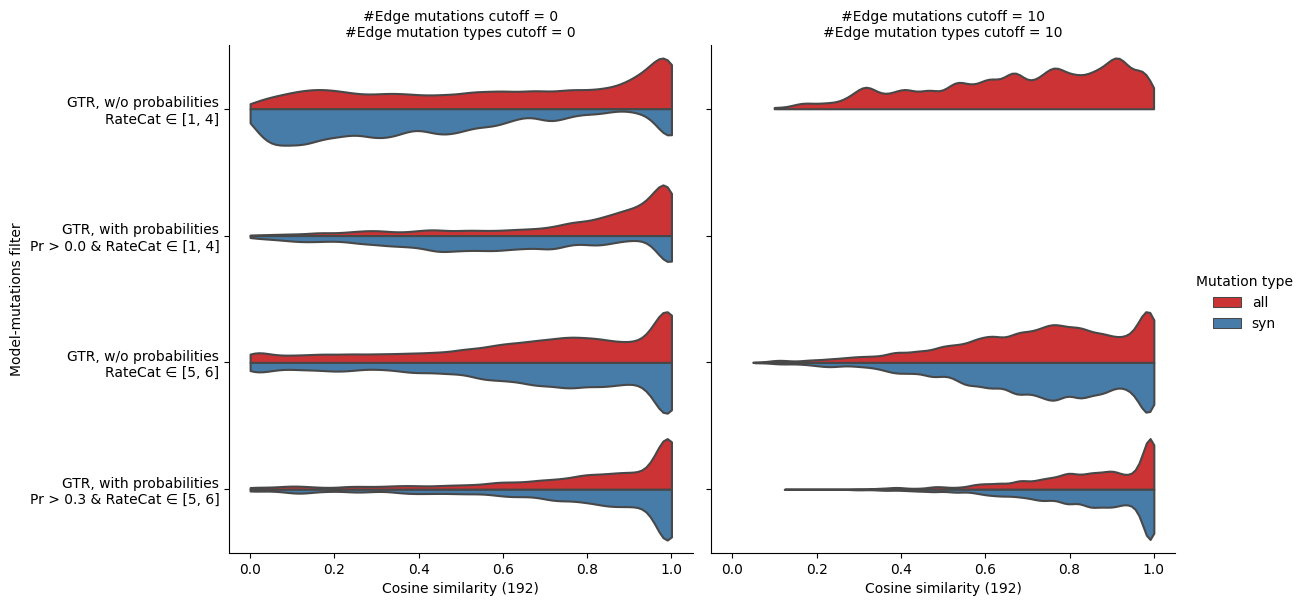

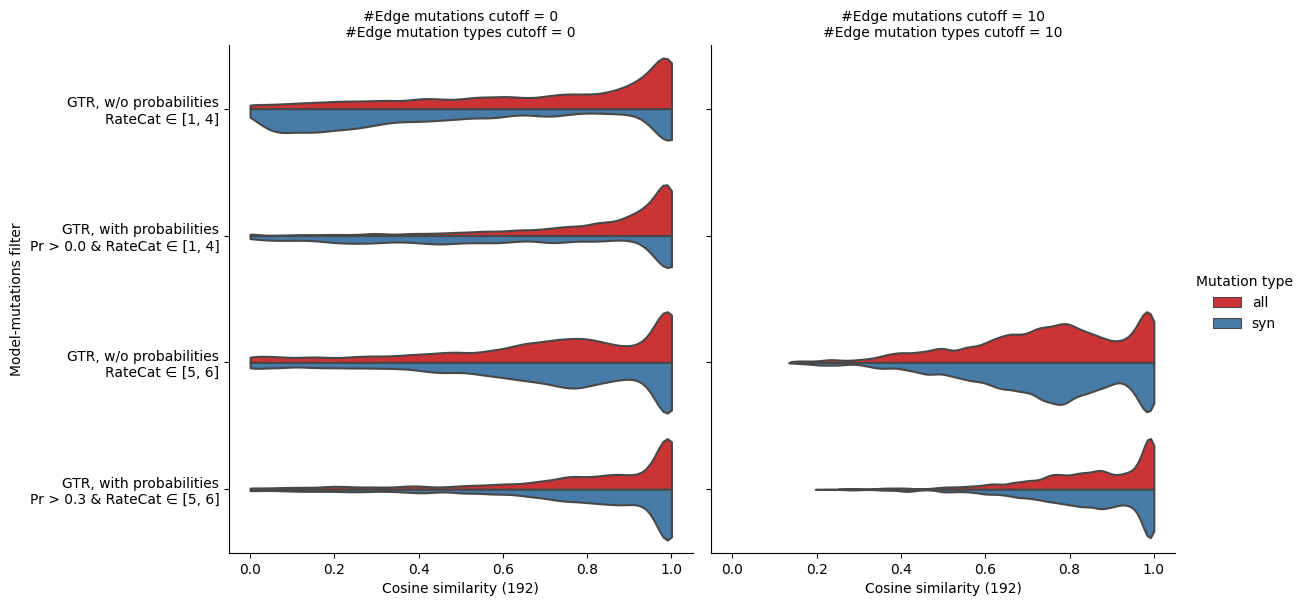

In [151]:
for gene in  ['cytb', 'nd1']:
    d = sim_df_mean[(sim_df_mean.Gene == gene)]
    g = sns.catplot(
        data=d, x="Sim", hue="Label", y="AppCond",
        col="FilterCond", col_order=['nmutypes0_nobs0', 'nmutypes10_nobs10'],
        order=[f'{apches[1]}_simple-unfiltered', f'{apches[1]}-unfiltered', 
               f'{apches[1]}_simple-filtered', f'{apches[1]}-filtered'],
        kind="violin", height=6, aspect=1, palette="Set1", split=True, cut=0, bw=.1, inner=None,
    )
    g.set_titles(template="{col_name}", size=10)
    g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
    g.set_axis_labels("Cosine similarity (192)", "Model-mutations filter")
    g.legend.set_title("Mutation type")

    ax1, ax2 = g.axes[0]
    ax1.title.set_text(unlabel_filter_cond(ax1.title.get_text()))
    ax2.title.set_text(unlabel_filter_cond(ax2.title.get_text()))    
    ax1.set_yticklabels([unlabel_app_cond(x.get_text()) for x in ax1.get_yticklabels()])

    g.savefig(f"../figures/approaches/cossim_compare/pastml_compare_{apches[1]}_{gene}.pdf");

### How many edges filtered out due to uncertainty principle application?

In [26]:
nmtypes_cutoff, nobs_cuttof, pcutoff

(10, 10, 0.3)

cytb
gtr        2318
RY10.12    2316
Name: number of used edges, dtype: int64

RY10.12    1472
gtr        1454
Name: number of used edges - ProbaMut > pcutoff, dtype: int64

RY10.12    1410
gtr        1393
Name: number of used edges - ProbaFull > pcutoff, dtype: int64


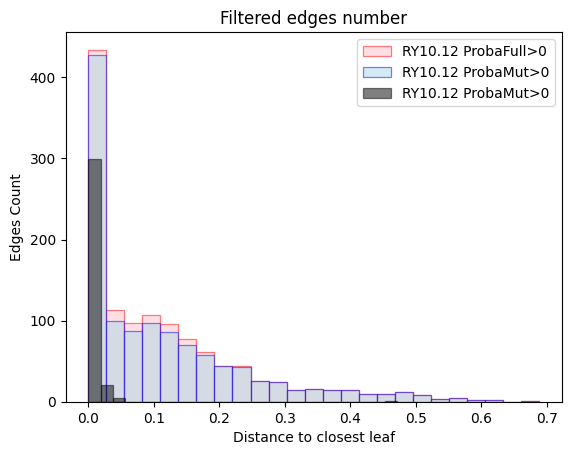

In [91]:
#cytb
print('cytb')
a = obs_cytb_unfiltered[obs_cytb_unfiltered.Aproach.isin(['gtr', 'RY10.12'])]\
    .groupby(['Aproach', 'AltNode', 'Mut']).ProbaMut.sum().unstack()
a = a[(((a > 0).sum(axis=1) >= nmtypes_cutoff) & (a.sum(axis=1) >= nobs_cuttof))]

print(a.index.get_level_values(0).value_counts().rename('number of used edges'))
print()

c = obs_cytb_unfiltered[(obs_cytb_unfiltered.Aproach.isin(['gtr', 'RY10.12'])) & (obs_cytb_filtered.ProbaMut > pcutoff)]\
    .groupby(['Aproach', 'AltNode', 'Mut']).ProbaMut.sum().unstack()
c = c[(((c > 0).sum(axis=1) >= nmtypes_cutoff) & (c.sum(axis=1) >= nobs_cuttof))]
print(c.index.get_level_values(0).value_counts().rename('number of used edges - ProbaMut > pcutoff'))
print()

b = obs_cytb_unfiltered[(obs_cytb_unfiltered.Aproach.isin(['gtr', 'RY10.12'])) & (obs_cytb_filtered.ProbaFull > pcutoff)]\
    .groupby(['Aproach', 'AltNode', 'Mut']).ProbaFull.sum().unstack()
b = b[(((b > 0).sum(axis=1) >= nmtypes_cutoff) & (b.sum(axis=1) >= nobs_cuttof))]
print(b.index.get_level_values(0).value_counts().rename('number of used edges - ProbaFull > pcutoff'))

plt.title('Filtered edges number')
plt.xlabel('Distance to closest leaf')
plt.ylabel('Edges Count')
plt.hist([dist2leaf_cytb[n] for n  in set(dist2leaf_cytb.keys()).difference(b.loc['RY10.12'].index.values)], bins=25, label='RY10.12 ProbaFull>0', alpha=0.5, color='pink', lw=0.9, ec="r")
plt.hist([dist2leaf_cytb[n] for n  in set(dist2leaf_cytb.keys()).difference(c.loc['RY10.12'].index.values)], bins=25, label='RY10.12 ProbaMut>0', alpha=0.5, color='lightblue', lw=0.9, ec="b")
plt.hist([dist2leaf_cytb[n] for n  in set(dist2leaf_cytb.keys()).difference(a.loc['RY10.12'].index.values)], bins=25, label='RY10.12 ProbaMut>0', alpha=0.5, color='k', lw=0.9, ec="k")
plt.legend()
plt.show()

nd1
RY10.12    2235
gtr        2233
Name: number of used edges, dtype: int64

RY10.12    1370
gtr        1353
Name: number of used edges - ProbaMut > pcutoff, dtype: int64

RY10.12    1317
gtr        1297
Name: number of used edges - ProbaFull > pcutoff, dtype: int64


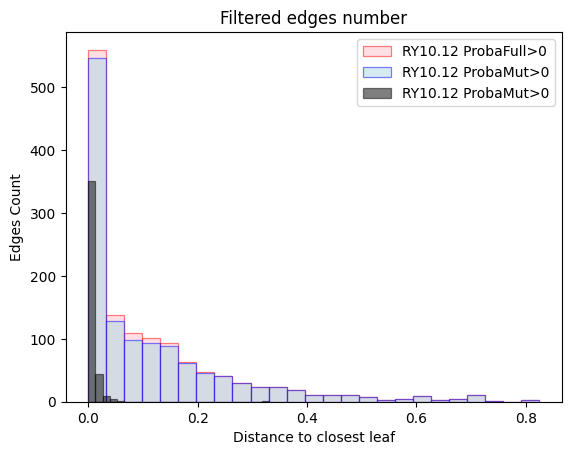

In [90]:
#nd1
print('nd1')
a = obs_nd1_unfiltered[obs_nd1_unfiltered.Aproach.isin(['gtr', 'RY10.12'])]\
    .groupby(['Aproach', 'AltNode', 'Mut']).ProbaMut.sum().unstack()
a = a[(((a > 0).sum(axis=1) >= nmtypes_cutoff) & (a.sum(axis=1) >= nobs_cuttof))]

print(a.index.get_level_values(0).value_counts().rename('number of used edges'))
print()

c = obs_nd1_unfiltered[(obs_nd1_unfiltered.Aproach.isin(['gtr', 'RY10.12'])) & (obs_nd1_filtered.ProbaMut > pcutoff)]\
    .groupby(['Aproach', 'AltNode', 'Mut']).ProbaMut.sum().unstack()
c = c[(((c > 0).sum(axis=1) >= nmtypes_cutoff) & (c.sum(axis=1) >= nobs_cuttof))]
print(c.index.get_level_values(0).value_counts().rename('number of used edges - ProbaMut > pcutoff'))
print()

b = obs_nd1_unfiltered[(obs_nd1_unfiltered.Aproach.isin(['gtr', 'RY10.12'])) & (obs_nd1_filtered.ProbaFull > pcutoff)]\
    .groupby(['Aproach', 'AltNode', 'Mut']).ProbaFull.sum().unstack()
b = b[(((b > 0).sum(axis=1) >= nmtypes_cutoff) & (b.sum(axis=1) >= nobs_cuttof))]
print(b.index.get_level_values(0).value_counts().rename('number of used edges - ProbaFull > pcutoff'))

plt.title('Filtered edges number')
plt.xlabel('Distance to closest leaf')
plt.ylabel('Edges Count')
plt.hist([dist2leaf_nd1[n] for n  in set(dist2leaf_nd1.keys()).difference(b.loc['RY10.12'].index.values)], bins=25, label='RY10.12 ProbaFull>0', alpha=0.5, color='pink', lw=0.9, ec="r")
plt.hist([dist2leaf_nd1[n] for n  in set(dist2leaf_nd1.keys()).difference(c.loc['RY10.12'].index.values)], bins=25, label='RY10.12 ProbaMut>0', alpha=0.5, color='lightblue', lw=0.9, ec="b")
plt.hist([dist2leaf_nd1[n] for n  in set(dist2leaf_nd1.keys()).difference(a.loc['RY10.12'].index.values)], bins=25, label='RY10.12 ProbaMut>0', alpha=0.5, color='k', lw=0.9, ec="k")
plt.legend()
plt.show()

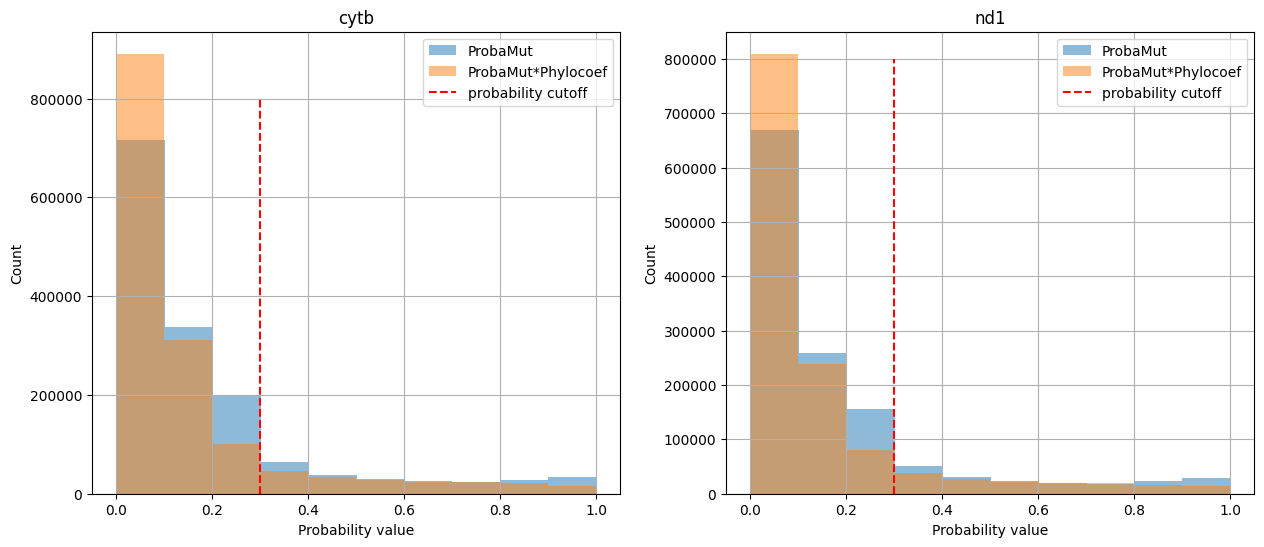

In [34]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
obs_cytb_unfiltered[obs_cytb_unfiltered.Aproach.isin(['gtr', 'RY10.12'])].ProbaMut.hist(label='ProbaMut', alpha=0.5)
obs_cytb_unfiltered[obs_cytb_unfiltered.Aproach.isin(['gtr', 'RY10.12'])].ProbaFull.hist(label='ProbaMut*Phylocoef', alpha=0.5)
plt.vlines(0.3, 0, 800000, 'r', '--', label='probability cutoff')
plt.title('cytb')
plt.xlabel('Probability value')
plt.ylabel('Count')
plt.legend()

plt.subplot(122)
obs_nd1_unfiltered[obs_nd1_unfiltered.Aproach.isin(['gtr', 'RY10.12'])].ProbaMut.hist(label='ProbaMut', alpha=0.5)
obs_nd1_unfiltered[obs_nd1_unfiltered.Aproach.isin(['gtr', 'RY10.12'])].ProbaFull.hist(label='ProbaMut*Phylocoef', alpha=0.5)
plt.vlines(0.3, 0, 800000, 'r', '--', label='probability cutoff')
plt.title('nd1')
plt.xlabel('Probability value')
plt.ylabel('Count')
plt.legend()
plt.show()

### SYN vs SYN_C

In [35]:
data = []
for gene, obs, exp in zip(["cytb", "nd1"], [obs_cytb_filtered, obs_nd1_filtered], [freqs_cytb_filtered, freqs_nd1_filtered]):
    exp_gene_syn   = exp[exp.Label == "syn"].set_index(["Aproach", "Node"])[possible_sbs192]
    exp_gene_syn_c = exp[exp.Label == "syn_c"].set_index(["Aproach", "Node"])[possible_sbs192]

    obs_gene_lbl = obs[(obs.Label >= lbl2lbl_id(lbl))].groupby(["Aproach", "RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0.)
    obs_gene_lbl = complete_sbs192_columns(obs_gene_lbl)


    assert (obs_gene_lbl.columns == exp_gene_syn.columns).all()
    assert (obs_gene_lbl.columns == exp_gene_syn_c.columns).all()
    
    for appr in obs_gene_lbl.index.get_level_values(0).unique():
        if "simple" in  appr:
            continue
        spectra_syn   = calc_edgewise_spectra(obs_gene_lbl.loc[appr], exp_gene_syn.loc[appr], 0, 0, True)
        spectra_syn_c = calc_edgewise_spectra(obs_gene_lbl.loc[appr], exp_gene_syn_c.loc[appr], 0, 0, True)
        sims = get_cossim(spectra_syn, spectra_syn_c)
        
        data.append((gene, appr, sims.values))
        
    print(gene)

sim_df_mean = pd.DataFrame(data, columns=["Gene", "Approach", "Sim"]).explode("Sim", True)
sim_df_mean.head()

cytb
nd1


,Gene,Approach,Sim
0,cytb,RY10.12,0.999549
1,cytb,RY10.12,0.999285
2,cytb,RY10.12,0.986317
3,cytb,RY10.12,0.995524
4,cytb,RY10.12,0.996523


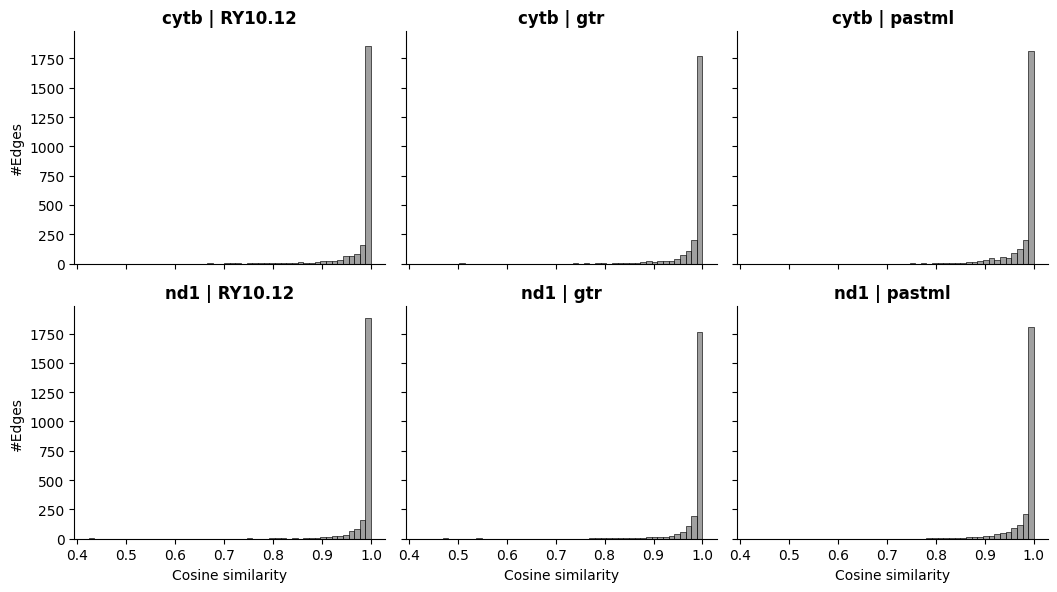

In [36]:
g = sns.displot(
    data=sim_df_mean, x="Sim", col="Approach", row="Gene",
    kind="hist", height=3, aspect=1.3, color="gray", bins=50,
    facet_kws=dict(sharex=True, sharey=True), #binrange=(0.75, 1.)
)
g.set_titles(template="{row_name} | {col_name}", fontweight='bold', size=12)
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
g.set_axis_labels("Cosine similarity", "#Edges")
plt.savefig(f"../figures/approaches/cossim_compare/pastml_compare_SYN_vs_SYN_C_pcutoff_{pcutoff}_catcutoff_{low_cat}_mtypes16_mnum20_.pdf")
plt.show()

## Categorizing mutations

In [23]:
mut_cytb.head()

,Mut,Label,PosInGene,RefNode,AltNode,Aproach,ProbaMut,ProbaFull,MutBase,Cat,RefPhylocoef,RefPhylocoefTrue,AltPhylocoefTrue,PhylocoefTotal,ProbaFull2,ProbaNotFull
0,T[T>A]A,0,33,Node208,Node209,gtr_simple,1.0,1.0,T>A,5,1.0,0.560181,0.655977,1.0,1.0,1.0
1,T[T>A]A,2,33,Node204,Node12,gtr_simple,1.0,1.0,T>A,5,1.0,0.560294,0.571026,1.0,1.0,1.0
2,T[A>T]A,0,33,Node223,Node224,gtr_simple,1.0,1.0,A>T,5,1.0,0.693228,0.796299,1.0,1.0,1.0
3,T[A>G]A,1,33,Node230,RN_36,gtr_simple,1.0,1.0,A>G,5,1.0,0.541164,1.000000,1.0,1.0,1.0
4,T[T>C]A,2,33,Node316,RN_807,gtr_simple,1.0,1.0,T>C,5,1.0,0.857343,1.000000,1.0,1.0,1.0


In [24]:
x = pd.concat([
    mut_cytb.assign(Gene="cytb"),
    mut_nd1.assign(Gene="nd1"),
  ]).groupby(["Gene", "Aproach", "Cat", "Label"]).ProbaFull.sum().unstack().fillna(0.)

x = x[[0,1,2,-2,-1]]
x.columns = x.columns.map({0: "non-syn", 1: "syn", 2: "syn4f", -2:"stop-loss", -1:"stop-gain", -3: "stop-to-stop"})
x["syn"] = x["syn"] + x["syn4f"]
x = x.reset_index().rename(columns={"Cat":"RateCat"})
x.to_csv("../data/share/nmuts_mammals.csv", index=False, float_format="%.2f")
x.head(6)

Label,Gene,Aproach,RateCat,non-syn,syn,syn4f,stop-loss,stop-gain
0,cytb,RY10.12,1,486.093316,10.054532,0.000000,0.353065,0.539241
1,cytb,RY10.12,2,1327.883319,31.685101,0.000000,3.953892,5.321798
2,cytb,RY10.12,3,2315.453419,517.162743,0.963448,15.754013,12.752437
3,cytb,RY10.12,4,1978.366821,6464.335007,260.834990,0.501398,0.047522
4,cytb,RY10.12,5,1378.534979,52224.990929,14800.966920,0.472059,0.029691
5,cytb,RY10.12,6,314.019945,43215.920667,38604.428300,0.214037,0.000000


In [25]:
x = pd.concat([
    mut_cytb[mut_cytb.ProbaFull > 0.3].assign(Gene="cytb"),
    mut_nd1[mut_nd1.ProbaFull > 0.3].assign(Gene="nd1"),
  ]).groupby(["Gene", "Aproach", "Cat", "Label"]).ProbaFull.sum().unstack().fillna(0.)

x = x[[0,1,2,-2,-1]]
x.columns = x.columns.map({0: "non-syn", 1: "syn", 2: "syn4f", -2:"stop-loss", -1:"stop-gain", -3: "stop-to-stop"})
x["syn"] = x["syn"] + x["syn4f"]
x = x.reset_index().rename(columns={"Cat":"RateCat"})
x.to_csv("../data/share/nmuts_mammals_filter_proba_03.csv", index=False, float_format="%.2f")

In [26]:
mut_cytb[mut_cytb.Label >= 0].groupby(["Aproach", "Label", "Cat"]).ProbaFull.sum().unstack().fillna(0).astype(int)

Cat                     1     2     3      4      5      6
Aproach        Label                                      
RY10.12        0      486  1327  2315   1978   1378    314
               1       10    31   516   6203  37424   4611
               2        0     0     0    260  14800  38604
RY10.12_simple 0      636  1832  3036   2568   1809    404
               1       11    36   606   6573  31201   2982
               2        0     0     1    279  13760  27252
gtr            0      486  1325  2291   2006   1401    303
               1        9    28   514   6145  36623   4545
               2        0     0     0    266  15451  38942
gtr_simple     0      644  1832  3010   2623   1853    394
               1       11    37   602   6527  30820   2991
               2        0     0     1    280  14118  27148
pastml         0      693  1795  2970   2476   1757    454
               1       14    35   738  10765  56569   4907
               2        0     0     1    361  20119  42069

In [218]:
mut_nd1[mut_nd1.Label >= 0].groupby(["Aproach", "Label", "Cat"]).ProbaFull.sum().unstack().fillna(0).astype(int)

Cat                     1     2     3     4      5      6
Aproach        Label                                     
RY10.12        0      289   789  1657  1579   1291    350
               1        1    39   110  2864  27553   6283
               2        0     0     0   104   6594  39446
RY10.12_simple 0      405  1148  2341  2218   1738    510
               1        1    41   128  3252  24705   4236
               2        0     0     0   112   6101  29515
gtr            0      290   787  1653  1589   1305    342
               1        1    37   110  2850  27067   6138
               2        0     0     0   105   6719  39634
gtr_simple     0      409  1129  2346  2246   1719    498
               1        1    41   131  3230  24446   4183
               2        0     0     0   111   6125  29349
pastml         0      429  1167  2112  2089   1745    529
               1        1    45   152  4531  44218   7261
               2        0     0     0   138   9168  44366

### SYN (phylo-like adjusting)

In [219]:
# space = [0.00, 0.05, 0.30, .50, 0.80, 1.00]
space = [0.00, 0.30, 1.00]

exp_cytb_syn = exp_cytb[exp_cytb.Label == 'syn']
exp_nd1_syn = exp_nd1[exp_nd1.Label == 'syn']

mut_cytb_syn = mut_cytb[mut_cytb.Label >= 1]
mut_nd1_syn = mut_nd1[mut_nd1.Label >= 1]

### Save mean spectra192 for different parameters of filtration

Correct method of tree spectra derivation

In [220]:
def assign_proba_cat(p: float, space=[0., 0.3, 1.0]):
    out = "{:.1f}_{:.1f}"
    for left, right in zip(space[:-1], space[1:]):
        if left <= p <= right:
            return out.format(left, right)
    raise NotImplementedError


assign_proba_cat(0.)

'0.0_0.3'

In [221]:
exp_cytb_syn[exp_cytb_syn.Proba > 1]

,Pos,Mut,Label,Node,Aproach,Proba,Cat,phylocoef,phylocoef_old,ProbaMut,Proba2,ProbaNotFull


In [222]:
exp_nd1_syn[exp_nd1_syn.Proba > 1]

,Pos,Mut,Label,Node,Aproach,Proba,Cat,phylocoef,phylocoef_old,ProbaMut,Proba2,ProbaNotFull


In [223]:
mut_cytb_syn['ProbaCat'] = mut_cytb_syn.ProbaFull.apply(assign_proba_cat)
mut_nd1_syn['ProbaCat']  = mut_nd1_syn.ProbaFull.apply(assign_proba_cat)

exp_cytb_syn['ProbaCat'] = exp_cytb_syn.Proba.apply(assign_proba_cat)
exp_nd1_syn['ProbaCat']  = exp_nd1_syn.Proba.apply(assign_proba_cat)

In [266]:
def _collapse_ratecats(x: int):
    if 1 <= x <= 4:
        cat_lbl = '1234'
    elif x == 5:
        cat_lbl = '5'
    elif x == 6:
        cat_lbl = '6'
    else:
        raise NotImplementedError
    return cat_lbl


def aggregate_ratecats(df: pd.DataFrame, add56=True):
    df = df.reset_index(-1)
    ind_cols = list(df.index.names) + ['RateCat']
    df['RateCat'] = df.Cat.apply(_collapse_ratecats)
    if add56:
        appendix = df[df['Cat'].isin([5,6])].sum(axis=0, level=[0,1,2])
        df = pd.concat([df, appendix])
    
    df = df.reset_index().drop('Cat', axis=1).sort_values(ind_cols).set_index(ind_cols)
    df = df.sum(axis=0, level=[0,1,2,3])
    return df

In [286]:
obs_freqs_total = complete_sbs192_columns(pd.concat([
    mut_cytb_syn[mut_cytb_syn.Aproach.isin(['gtr', 'RY10.12', 'pastml'])].assign(Gene='cytb'),
    mut_nd1_syn[mut_nd1_syn.Aproach.isin(['gtr', 'RY10.12', 'pastml'])].assign(Gene='nd1'),
]).groupby(['Gene', 'Aproach', 'ProbaCat', 'Cat', 'Mut']).ProbaFull.sum().unstack().fillna(0.))
obs_freqs_total = aggregate_ratecats(obs_freqs_total)

exp_freqs_total = complete_sbs192_columns(pd.concat([
    exp_cytb_syn[exp_cytb_syn.Aproach.isin(['gtr', 'RY10.12', 'pastml'])].assign(Gene='cytb'),
    exp_nd1_syn[exp_nd1_syn.Aproach.isin(['gtr', 'RY10.12', 'pastml'])].assign(Gene='nd1'),
]).groupby(['Gene', 'Aproach', 'ProbaCat', 'Cat', 'Mut']).Proba.sum().unstack().fillna(0.))
exp_freqs_total = aggregate_ratecats(exp_freqs_total)

assert (obs_freqs_total.columns == exp_freqs_total.columns).all()
assert (obs_freqs_total.index == exp_freqs_total.index).all()

spectra_total = (obs_freqs_total / exp_freqs_total).where((obs_freqs_total > 1) & (exp_freqs_total > 1)).fillna(0.)

#scale
spectra_total = (spectra_total.T / spectra_total.sum(axis=1)).T
spectra_total_long = spectra_total.reset_index().melt(['Gene', 'Aproach', 'ProbaCat', 'RateCat'], possible_sbs192, value_name='MutSpec')

In [323]:
# non-zero values count
(spectra_total > 0).sum(axis=1).unstack()

RateCat                1234    5   56    6
Gene Aproach ProbaCat                     
cytb RY10.12 0.0_0.3     51  151  160  152
             0.3_1.0     56  143  156  142
     gtr     0.0_0.3     56  154  160  152
             0.3_1.0     56  146  159  143
     pastml  0.0_0.3     56  145  160  149
             0.3_1.0     58  144  158  145
nd1  RY10.12 0.0_0.3     34  127  160  158
             0.3_1.0     36  122  155  141
     gtr     0.0_0.3     34  139  160  158
             0.3_1.0     36  126  157  145
     pastml  0.0_0.3     36  123  160  155
             0.3_1.0     38  123  157  150

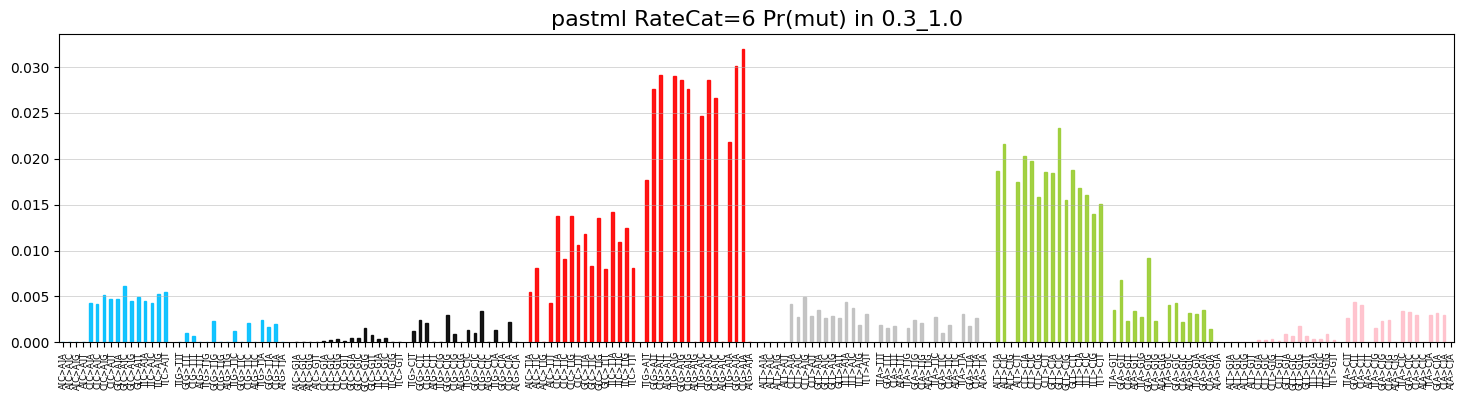

<AxesSubplot:title={'center':'pastml RateCat=6 Pr(mut) in 0.3_1.0'}>

In [324]:
gene, apr, _ratecat, _probacat = 'cytb', 'pastml', '6', '0.3_1.0'
df = spectra_total_long[(spectra_total_long.Gene == gene) & (spectra_total_long.Aproach == apr) & \
                             (spectra_total_long.RateCat == _ratecat) & (spectra_total_long.ProbaCat == _probacat)]
plot_mutspec192(df, title=f'{apr} RateCat={_ratecat} Pr(mut) in {_probacat}', figsize=(18, 4))

In [325]:
spectra_total.to_csv('../data/share/mean_mammals_spectra.csv', float_format='%g')

### PLOT barplots

In [327]:
base_outpath = '../figures/approaches/mammals_{gene}_{apr}_{lbl}_ratecat{ratecat}.{ext}'

df_to_plot = spectra_total_long.copy()

for gene in df_to_plot.Gene.unique():
    print(gene)
    for apr in df_to_plot.Aproach.unique():
        print(apr)
        for rt in df_to_plot.RateCat.unique():
            if rt != '56':
                continue
            
            df = df_to_plot[
                (df_to_plot.Gene == gene) & \
                (df_to_plot.Aproach == apr) & \
                (df_to_plot.RateCat == rt)
            ]
            plt.figure(figsize=(50, 10))
            sns.barplot(
                x="Mut", y="MutSpec", hue="ProbaCat", data=df, 
                errwidth=1, order=ordered_sbs192_kp, palette="Blues",
            )
            plt.title(f"{apr} {lbl} {rt} rate")
            plt.xticks(rotation=90)
            plt.savefig(base_outpath.format(gene=gene, apr=apr, lbl=lbl, ratecat=rt, ext='svg'), bbox_inches="tight")
            plt.savefig(base_outpath.format(gene=gene, apr=apr, lbl=lbl, ratecat=rt, ext='pdf'), bbox_inches="tight")
            plt.close()


cytb
RY10.12
gtr
pastml
nd1
RY10.12
gtr
pastml


In [328]:
mean_mammals_spectra = pd.read_csv('../data/share/mean_mammals_spectra.csv', index_col=[0,1,2,3])
mean_mammals_spectra.columns.name = 'Mut'
mean_mammals_spectra.head(2)

Mut                            A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T   C[A>C]A  \
Gene Aproach ProbaCat RateCat                                                 
cytb RY10.12 0.0_0.3  1234           0        0        0        0  0.008811   
                      5              0        0        0        0  0.004217   

Mut                             C[A>C]C   C[A>C]G  C[A>C]T   G[A>C]A  \
Gene Aproach ProbaCat RateCat                                          
cytb RY10.12 0.0_0.3  1234     0.000000  0.000000  0.00000  0.000000   
                      5        0.005121  0.003935  0.00655  0.009162   

Mut                             G[A>C]C  ...   C[T>G]G   C[T>G]T  G[T>G]A  \
Gene Aproach ProbaCat RateCat            ...                                
cytb RY10.12 0.0_0.3  1234     0.000000  ...  0.000000  0.000000      0.0   
                      5        0.008125  ...  0.000113  0.000058      0.0   

Mut                            G[T>G]C   G[T>G]G  G[T>G]T  T[T>G]A   T[T>G]C  \
Gene Aproach ProbaCat RateCat                                                  
cytb RY10.12 0.0_0.3  1234         0.0  0.000000      0.0  0.00000  0.000000   
                      5            0.0  0.000755      0.0  0.00012  0.000243   

Mut                             T[T>G]G   T[T>G]T  
Gene Aproach ProbaCat RateCat                      
cytb RY10.12 0.0_0.3  1234     0.000000  0.000000  
                      5        0.000118  0.000285  

[2 rows x 192 columns]

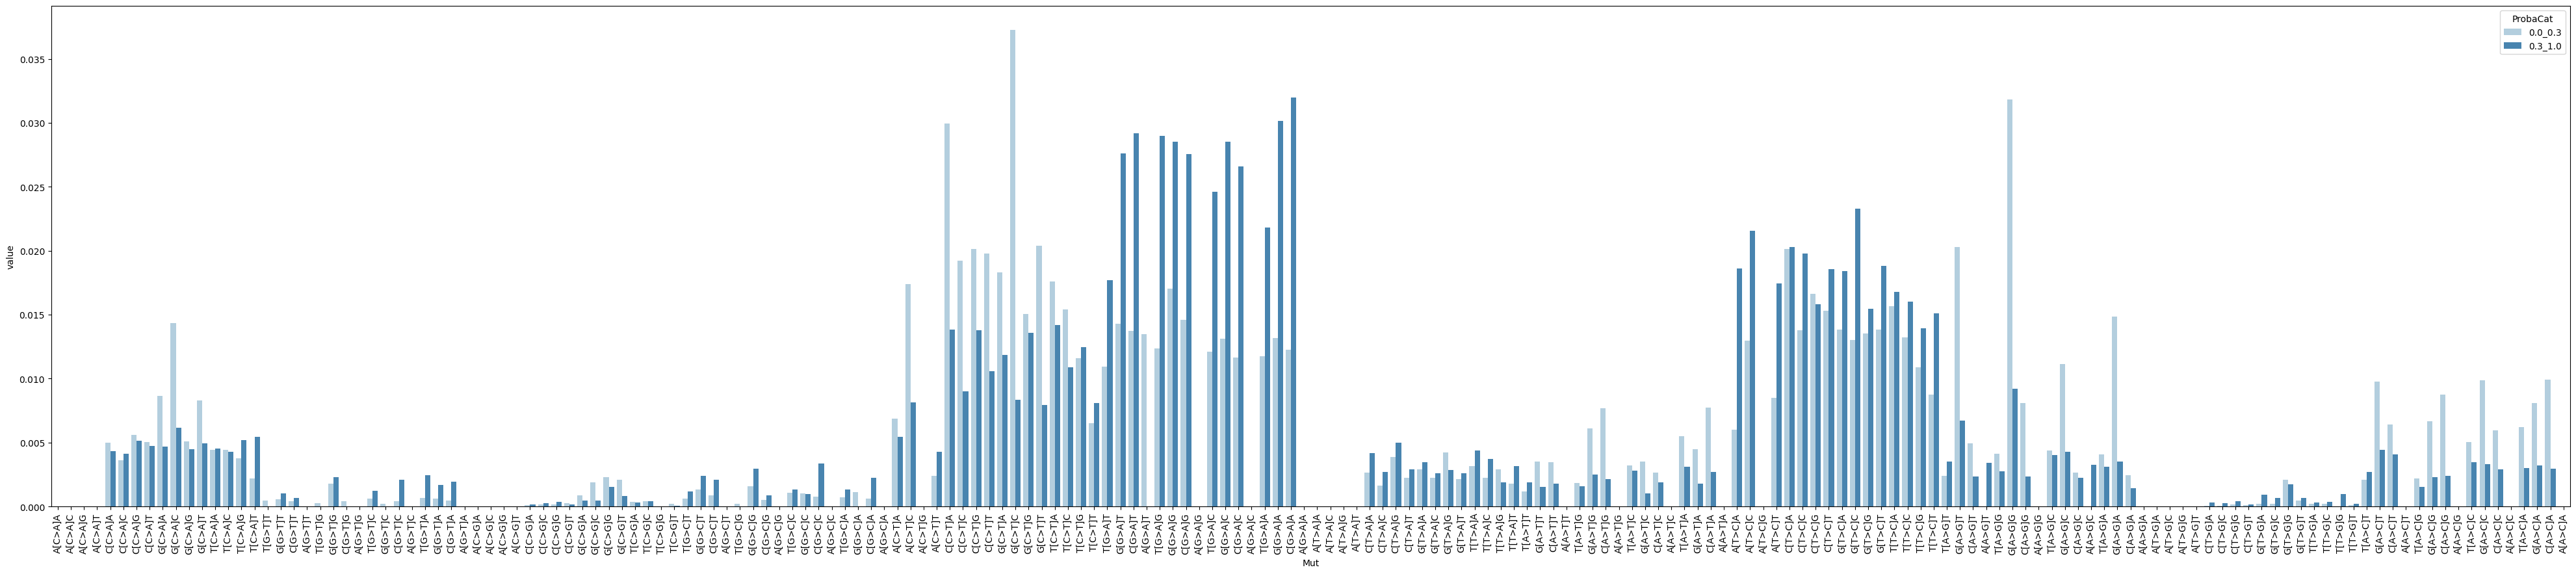

In [329]:
# check that mean values 
df = mean_mammals_spectra.reset_index().melt(mean_mammals_spectra.index.names, possible_sbs192)

plt.figure(figsize=(50, 10))
sns.barplot(
    x="Mut", y="value", hue="ProbaCat", 
    data=df[(df.Gene=='cytb')&(df.Aproach=='pastml')&(df.RateCat==6)], 
    errwidth=1, order=ordered_sbs192_kp, palette="Blues",
)
plt.xticks(rotation=90);
# plt.savefig(base_outpath.format(gene=gene, apr=apr, lbl=lbl, ratecat=rt, ext='svg'), bbox_inches="tight")
# plt.savefig(base_outpath.format(gene=gene, apr=apr, lbl=lbl, ratecat=rt, ext='pdf'), bbox_inches="tight")
# plt.close()

### SYN (phylo-like adjusting) LEGACY

In [ ]:
def calc_tree_mutspec2(mut: pd.DataFrame, freqs, lbl="syn", pmin=0.0, pmax=1.0, scale=True):
    mut = mut[
        (mut.Label >= lbl2lbl_id(lbl)) & 
        (mut.ProbaFull.between(pmin, pmax, "right"))
    ]
    # print("#mutations:", mut.ProbaFull.sum())
    if mut.ProbaFull.sum() < 100:
        return None
    mut = mut.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
    assert len(mut) > 0
            
    mut = complete_sbs192_columns(mut)
    
    freqs = freqs[freqs.Label == lbl]
    edges_df = mut.index.to_frame(False)

    freqs = edges_df.merge(freqs, left_on="RefNode", right_on="Node")\
        .set_index(["RefNode", "AltNode"])[possible_sbs192]
    
    assert (mut.columns == freqs.columns).all()
    assert (mut.index == freqs.index).all()

    spectra = (mut / freqs).fillna(0.)
    if scale:
        spectra = (spectra.T / spectra.T.sum(axis=0)).T

    return spectra


In [ ]:
# space = [0.00, 0.05, 0.30, .50, 0.80, 1.00]
space = [0.00, 0.30, 1.00]

In [44]:
low_cat = 4
pcutoff = 0.3

freqs_nd1_high_rate  = exp_nd1[(exp_nd1.Cat   > low_cat) & (exp_nd1.Proba  > pcutoff)].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)
freqs_cytb_high_rate = exp_cytb[(exp_cytb.Cat > low_cat) & (exp_cytb.Proba > pcutoff)].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)

assert freqs_nd1_high_rate.shape[1] == 192
assert freqs_cytb_high_rate.shape[1] == 192

freqs_nd1_high_rate  = freqs_nd1_high_rate.reset_index()
freqs_cytb_high_rate = freqs_cytb_high_rate.reset_index()


freqs_nd1_low_rate = exp_nd1[(exp_nd1.Cat <= low_cat) & (exp_nd1.Proba > pcutoff)].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)
freqs_cytb_low_rate = exp_cytb[(exp_cytb.Cat <= low_cat) & (exp_cytb.Proba > pcutoff)].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)

assert freqs_nd1_low_rate.shape[1] == 192
assert freqs_cytb_low_rate.shape[1] == 192

freqs_nd1_low_rate = freqs_nd1_low_rate.reset_index()
freqs_cytb_low_rate = freqs_cytb_low_rate.reset_index()

<AxesSubplot:>

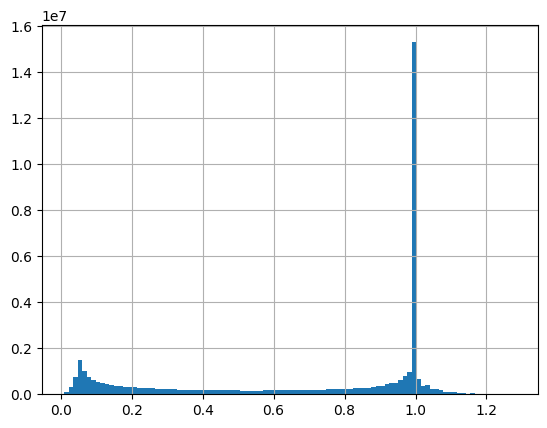

In [45]:
exp_nd1.Proba.hist(bins=100)

<AxesSubplot:>

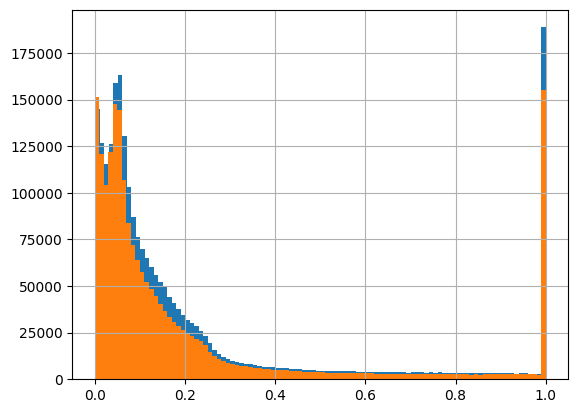

In [46]:
mut_cytb.ProbaFull.hist(bins=100)
mut_nd1.ProbaFull.hist(bins=100)

In [17]:
mut_cytb.head()

,Mut,Label,PosInGene,RefNode,AltNode,Aproach,ProbaMut,ProbaFull,MutBase,Cat
0,T[T>A]A,0,33,Node208,Node209,gtr_simple,1.0,1.0,T>A,5
1,T[T>A]A,2,33,Node204,Node12,gtr_simple,1.0,1.0,T>A,5
2,T[A>T]A,0,33,Node223,Node224,gtr_simple,1.0,1.0,A>T,5
3,T[A>G]A,1,33,Node230,RN_36,gtr_simple,1.0,1.0,A>G,5
4,T[T>C]A,2,33,Node316,RN_807,gtr_simple,1.0,1.0,T>C,5


In [19]:
lbl = "syn"

ms_cat_cytb = []
ms_cat_nd1 = []

for apr in mut_cytb.Aproach.unique():
    if "simple" in apr:
        continue
    mapr_cytb = mut_cytb[(mut_cytb.Aproach == apr)]
    mapr_nd1  = mut_nd1[(mut_nd1.Aproach == apr)]

    for p1, p2 in zip(space[:-1], space[1:]):
        # CYTB
        ms_low_rate = calc_tree_mutspec2(
            mapr_cytb[(mapr_cytb.Cat <= low_cat)],
            freqs_cytb_low_rate[freqs_cytb_low_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_low_rate is not None:
            ms_cat_cytb.append(ms_low_rate.assign(Cat=f'{p1:.2f}_{p2:.2f}', Aproach=apr, Rate='low'))

        ms_high_rate = calc_tree_mutspec2(
            mapr_cytb[(mapr_cytb.Cat > low_cat)], 
            freqs_cytb_high_rate[freqs_cytb_high_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_high_rate is not None:
            ms_cat_cytb.append(ms_high_rate.assign(Cat=f'{p1:.2f}_{p2:.2f}', Aproach=apr, Rate='high'))

        # ND1
        ms_low_rate = calc_tree_mutspec2(
            mapr_nd1[(mapr_nd1.Cat <= low_cat)], 
            freqs_nd1_low_rate[freqs_nd1_low_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_low_rate is not None:
            ms_cat_nd1.append(ms_low_rate.assign(Cat=f'{p1:.2f}_{p2:.2f}', Aproach=apr, Rate='low'))

        ms_high_rate = calc_tree_mutspec2(
            mapr_nd1[(mapr_nd1.Cat > low_cat)], 
            freqs_nd1_high_rate[freqs_nd1_high_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_high_rate is not None:
            ms_cat_nd1.append(ms_high_rate.assign(Cat=f'{p1:.2f}_{p2:.2f}', Aproach=apr, Rate='high'))
    
ms_cat_cytb_df = pd.concat(ms_cat_cytb)
ms_cat_nd1_df = pd.concat(ms_cat_nd1)

In [20]:
ms_cat_cytb_df

Mut               A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T  C[A>C]A  C[A>C]C  \
RefNode AltNode                                                          
Node1   Node1320      0.0      0.0      0.0      0.0      0.0      0.0   
        RN_1          0.0      0.0      0.0      0.0      0.0      0.0   
Node10  Node389       0.0      0.0      0.0      0.0      NaN      0.0   
        Node9         0.0      0.0      0.0      0.0      NaN      0.0   
Node100 RN_159        0.0      0.0      0.0      0.0      0.0      0.0   
...                   ...      ...      ...      ...      ...      ...   
Node997 RN_707        0.0      0.0      0.0      0.0      0.0      0.0   
Node998 RN_710        0.0      0.0      0.0      0.0      0.0      0.0   
        RN_711        0.0      0.0      0.0      0.0      0.0      0.0   
Node999 Node1000      0.0      0.0      0.0      0.0      0.0      0.0   
        RN_718        0.0      0.0      0.0      0.0      0.0      0.0   

Mut               C[A>C]G  C[A>C]T   G[A>C]A   G[A>C]C  ...  G[T>G]C  G[T>G]G  \
RefNode AltNode                                         ...                     
Node1   Node1320      0.0      0.0  0.000000  0.000000  ...      0.0      0.0   
        RN_1          0.0      0.0  0.000000  0.000000  ...      0.0      0.0   
Node10  Node389       0.0      0.0  0.000000  0.000000  ...      0.0      0.0   
        Node9         0.0      0.0  0.000000  0.000000  ...      0.0      0.0   
Node100 RN_159        0.0      0.0  0.000000  0.000000  ...      0.0      0.0   
...                   ...      ...       ...       ...  ...      ...      ...   
Node997 RN_707        0.0      0.0  0.000000  0.000000  ...      0.0      0.0   
Node998 RN_710        0.0      0.0  0.000000  0.000000  ...      0.0      0.0   
        RN_711        0.0      0.0  0.000000  0.000000  ...      0.0      0.0   
Node999 Node1000      0.0      0.0  0.000000  0.240645  ...      0.0      0.0   
        RN_718        0.0      0.0  0.032282  0.000000  ...      0.0      0.0   

Mut               G[T>G]T  T[T>G]A  T[T>G]C  T[T>G]G  T[T>G]T        Cat  \
RefNode AltNode                                                            
Node1   Node1320      0.0      0.0      0.0      0.0      0.0  0.00_0.30   
        RN_1          0.0      0.0      0.0      0.0      0.0  0.00_0.30   
Node10  Node389       0.0      0.0      0.0      0.0      0.0  0.00_0.30   
        Node9         0.0      0.0      0.0      0.0      0.0  0.00_0.30   
Node100 RN_159        0.0      0.0      0.0      0.0      0.0  0.00_0.30   
...                   ...      ...      ...      ...      ...        ...   
Node997 RN_707        0.0      0.0      0.0      0.0      0.0  0.30_1.00   
Node998 RN_710        0.0      0.0      0.0      0.0      0.0  0.30_1.00   
        RN_711        0.0      0.0      0.0      0.0      0.0  0.30_1.00   
Node999 Node1000      0.0      0.0      0.0      0.0      0.0  0.30_1.00   
        RN_718        0.0      0.0      0.0      0.0      0.0  0.30_1.00   

Mut               Aproach  Rate  
RefNode AltNode                  
Node1   Node1320      gtr   low  
        RN_1          gtr   low  
Node10  Node389       gtr   low  
        Node9         gtr   low  
Node100 RN_159        gtr   low  
...                   ...   ...  
Node997 RN_707     pastml  high  
Node998 RN_710     pastml  high  
        RN_711     pastml  high  
Node999 Node1000   pastml  high  
        RN_718     pastml  high  

[27742 rows x 195 columns]

#### Write to files

In [21]:
ms_cat_cytb_df_long = ms_cat_cytb_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat", "Rate"], possible_sbs192, value_name="MutSpec")
ms_cat_nd1_df_long  = ms_cat_nd1_df.reset_index().melt( ["Aproach", "RefNode", "AltNode", "Cat", "Rate"], possible_sbs192, value_name="MutSpec")

# write images
for apr in ms_cat_cytb_df_long.Aproach.unique():
    if "simple" in apr:
        continue
    print(apr)
    for rt in ms_cat_cytb_df_long.Rate.unique():
        if rt == "low":
            continue
        plt.figure(figsize=(50, 10))
        sns.barplot(
            x="Mut", y="MutSpec", hue="Cat", data=ms_cat_cytb_df_long[(ms_cat_cytb_df_long.Aproach == apr) & (ms_cat_cytb_df_long.Rate == rt)], 
            errwidth=1, order=ordered_sbs192_kp, palette="Blues",
        )
        plt.title(f"{apr} {lbl} {rt} rate")
        plt.xticks(rotation=90)
        plt.savefig(f"../figures/approaches/ex{low_cat}/mammals_cytb_{apr}_{lbl}_{rt}_rate_reduced_cats.svg", bbox_inches="tight")
        plt.savefig(f"../figures/approaches/ex{low_cat}/mammals_cytb_{apr}_{lbl}_{rt}_rate_reduced_cats.pdf", bbox_inches="tight")
        plt.close()

        plt.figure(figsize=(50, 10))
        sns.barplot(
            x="Mut", y="MutSpec", hue="Cat", data=ms_cat_nd1_df_long[(ms_cat_nd1_df_long.Aproach == apr) & (ms_cat_nd1_df_long.Rate == rt)], 
            errwidth=1, order=ordered_sbs192_kp, palette="Blues",
        )
        plt.title(f"{apr} {lbl} {rt} rate")
        plt.xticks(rotation=90)
        plt.savefig(f"../figures/approaches/ex{low_cat}/mammals_nd1_{apr}_{lbl}_{rt}_rate_reduced_cats.svg", bbox_inches="tight")
        plt.savefig(f"../figures/approaches/ex{low_cat}/mammals_nd1_{apr}_{lbl}_{rt}_rate_reduced_cats.pdf", bbox_inches="tight")
        plt.close()

gtr
RY10.12
pastml
